# September 18 Meeting Notebook

This notebook is to categorize the exploration taken for the project as of September 18, 2025.

## Objectives

The objectives for this meeting are to:

1. Run the LSTM code for Fresno Agg. Data
2. Break down the feature vector into its components:
    - For each component, compare sliding window length for its comparison for VFRates.
3. Once (2) is completed, create a padding function and mask function that allows the new LSTM to take into account the individual sliding windows so see if analysis changes.

In [1]:
# load in the fresno aggregate data 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys 
import os 

sys.path.append(os.path.abspath('..')) 

df_fresno = pd.read_csv("../../data/Fresno_Aggregate.csv")

In [2]:
# print the head to make sure we have the right data loaded
df_fresno.head()

Year-Month    VFRate  FIRE_Acres_Burned  PRECIP  WIND_EventCount  \
0    2008-10  6.156349             163.91    0.18              0.0   
1    2008-11  3.407979              17.30    1.49              0.0   
2    2008-12  6.486154               0.00    1.19              0.0   
3    2009-01  6.619800               1.00    1.25              0.0   
4    2009-02  5.751629              28.00    2.33              0.0   

   WIND_AvgMPH  WIND_RunMiles  AQI_PM25  AQI_PM10  EARTHQUAKE_Total  \
0     3.667742      87.825806      70.0      53.0                 0   
1     3.106667      74.490000      95.5      38.5                 0   
2     3.306452      79.312903      94.0      18.5                 0   
3     2.587097      62.019355     102.0      33.0                 0   
4     3.928571      94.096429      51.5      13.0                 0   

   PESTICIDE_Total  
0        23.056051  
1         0.519323  
2         0.000000  
3        24.630400  
4        71.542885

In [3]:
from models import LSTM 

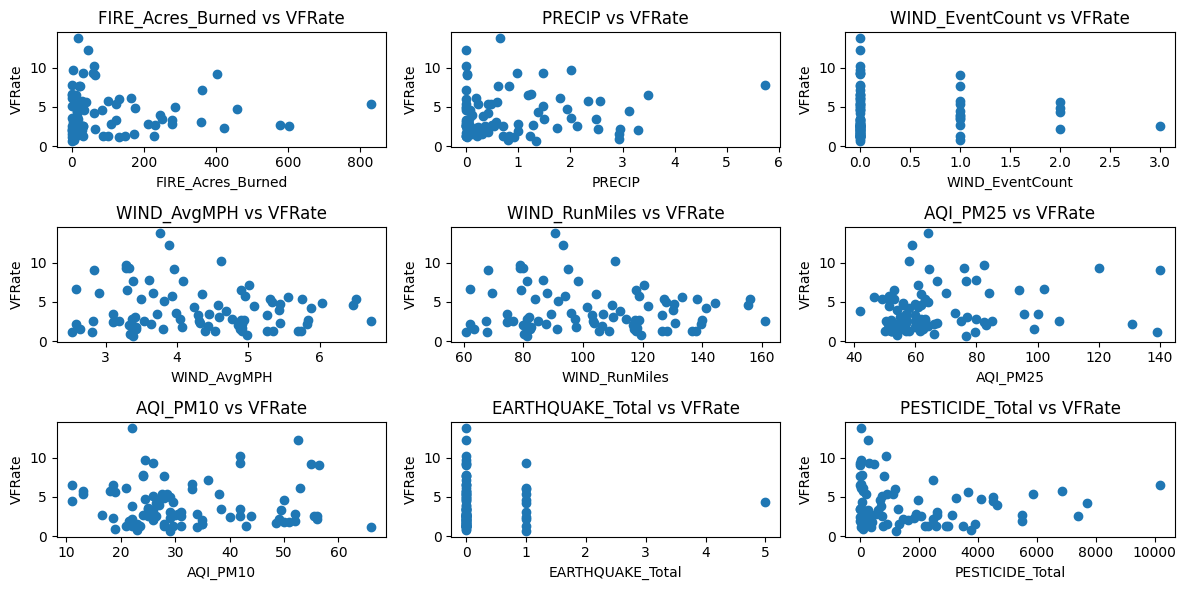

In [4]:
# Prepare features for LSTM
# Exclude 'Year-Month' and 'VFRate' (target variable)
feature_columns = ['FIRE_Acres_Burned', 'PRECIP', 'WIND_EventCount', 'WIND_AvgMPH', 
				  'WIND_RunMiles', 'AQI_PM25', 'AQI_PM10', 'EARTHQUAKE_Total', 'PESTICIDE_Total']

# Create X (features) and y (target)
X = df_fresno[feature_columns].values
y = df_fresno['VFRate'].values

# Plot correlation between features and VFRate
plt.figure(figsize=(12, 6))
for i, feature in enumerate(feature_columns):
	plt.subplot(3, 3, i+1)
	plt.scatter(df_fresno[feature], df_fresno['VFRate'])
	plt.xlabel(feature)
	plt.ylabel('VFRate')
	plt.title(f'{feature} vs VFRate')

plt.tight_layout()
plt.show()


In [5]:
# now what we want to do is loop through each feature and run the LSTM on each feature individually with a list of
# sliding window sizes and see which feature and sliding window size gives us the best performance
sliding_window_sizes = [1, 3, 6, 8, 12]
results = []

# probably need to make a function that preprocesses the "feature vector" for each run, turn into tensors
# test/train split, scale, and then run the LSTM model
def preprocess_data(X, y, feature_index, window_size, test_size=0.2):
  # Select the feature column
  if feature_index is not None:
    X_feature = X[:, feature_index].reshape(-1, 1)
  else:
    X_feature = X # its the whole feautre set

  # Create sequences for LSTM
  X_sequences, y_sequences = [], []
  for i in range(len(X_feature) - window_size):
    X_sequences.append(X_feature[i:i+window_size])
    y_sequences.append(y[i+window_size])

  X_sequences = np.array(X_sequences)
  y_sequences = np.array(y_sequences)

  # Train-test split
  split_index = int(len(X_sequences) * (1 - test_size))
  X_train, X_test = X_sequences[:split_index], X_sequences[split_index:]
  y_train, y_test = y_sequences[:split_index], y_sequences[split_index:]

  return X_train, X_test, y_train, y_test 

# before we plug into the lstm we need minmax scaling too
from sklearn.preprocessing import MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

def scale_data(X_train, X_test, y_train, y_test):
  # Reshape for scaling
  num_samples, window_size, num_features = X_train.shape
  X_train_reshaped = X_train.reshape(-1, num_features)
  X_test_reshaped = X_test.reshape(-1, num_features)

  # Scale features
  X_train_scaled = scaler_X.fit_transform(X_train_reshaped).reshape(num_samples, window_size, num_features)
  X_test_scaled = scaler_X.transform(X_test_reshaped).reshape(X_test.shape[0], window_size, num_features)

  # Scale target
  y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
  y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

  return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled

# below are model parameters 
# model parameters
# lookback has been removed because we are varying the sliding window size
hidden_size          = 32
num_layers           = 2
dropout              = 0.2
learning_rate        = 0.001
epochs               = 300
weight_decay         = 1e-5


In [6]:
# below is my training function for you to utilize 
import torch 
import numpy as np
import matplotlib.pyplot as plt 
from datetime import date

# Creating a Trainer Class to contain Training/Testing/Visualizing
class TrainerNewNew:
  """
  Trainer Class: A class that contains the training, testing, and visualization functions.
  """
  def __init__(self, model, criterion, optimizer, scaler):
    """
    Initialize the class. Takes in a model, crtierion for loss, optimizer, scaler.
    
    Inputs:
      - Model: Neural Network model
      - Criterion: Loss function (Typically MSELoss for time series, may look into more)
      - Optimizer: Optimizer with learning rate added. Typically using Adam
      - Scaler: MinMaxScaler scaler value, used for inverse transform to get actual data back
    """
    self.model     = model 
    self.criterion = criterion 
    self.optimizer = optimizer
    self.scaler    = scaler
  
  def train(self, X_train, y_train, X_test, y_test, epochs):
    history = {'train_loss': [], 'test_loss': []}

    for epoch in range(epochs):
        self.model.train()
        output = self.model(X_train)
        loss = self.criterion(output, y_train)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        history['train_loss'].append(loss.item())
        
        if epoch % 10 == 0:
            self.model.eval()
            with torch.no_grad():
                val_loss = self.criterion(self.model(X_test), y_test)
                history['test_loss'].append(val_loss.item())
                print(f"Epoch {epoch+1}/{epochs} - Training Loss {loss.item():.4f}, Testing Loss {val_loss.item():.4f}")
    
    # Capture the final training predictions
    self.model.eval()
    with torch.no_grad():
        final_train_preds = self.model(X_train).detach().cpu().numpy()
        
    # Also inverse transform the training data for later plotting
    y_train_true = self.scaler.inverse_transform(y_train.cpu().numpy().reshape(-1, 1)).flatten()
    final_train_preds_inv = self.scaler.inverse_transform(final_train_preds).flatten()
    
    return history, final_train_preds_inv, y_train_true
    
  def evaluate(self, X_test, y_test):
    """
    Evaluation Loop. Evaluates the model and generates predictions.

    Inputs:
      - X_test: Test matrix X
      - y_test: Test target vector y
    
    Outputs:
      - y_pred: predicted target vector from the model using X_test
      - y_true: True target vector (y_test)
    """
    self.model.eval()
    with torch.no_grad():
        preds = self.model(X_test).detach().cpu().numpy()

        # Inverse transform the predictions using the y_scaler
        # The y_scaler was fit on a 1-D array, so the predictions should be reshaped
        vf_pred = self.scaler.inverse_transform(preds)

        # Inverse transform the true values using the y_scaler
        # The y_scaler was fit on a 1-D array, so the true values should be reshaped
        vf_true = self.scaler.inverse_transform(y_test.cpu().numpy())
        
    return vf_pred.flatten(), vf_true.flatten()
  
  def visualize_results(self, true, pred, county_name="", model_type = "LSTM", title_text = "", show_plot = True, save_fig = False):
    """
    Function to visualize the prediction vs true (test) vector

    Inputs:
      - True: True data (test or validation target vector)
      - Pred: Prediction data from the model evaluation function
    """
    if show_plot:
      plt.figure(figsize=(12, 6))
      plt.plot(true, label="True Values")
      plt.plot(pred[1:], label = "Predicted Values", linestyle="--")
      plt.title(f"{county_name} {model_type} {title_text} True vs Predicted Valley Fever Case Rates")
      plt.xlabel("Months")
      plt.ylabel("Case Rates")
      plt.legend()
      plt.grid(True)
      plt.tight_layout()
      plt.show()
    
    if save_fig:
      plt.figure(figsize=(12, 6))
      plt.plot(true, label="True Values")
      plt.plot(pred[1:], label = "Predicted Values", linestyle="--")
      plt.title(f"{county_name} {model_type} {title_text} LSTM True vs Predicted Valley Fever Case Rates")
      plt.xlabel("Months")
      plt.ylabel("Case Rates")
      plt.legend()
      plt.grid(True)
      plt.tight_layout()
      img_str = f"Project/plots/{model_type}/{county_name}_{title_text}_plot_{date.today()}.png"
      plt.savefig(img_str)

In [7]:
from loss_functions import RMSELoss
import torch.optim as optim 

criterion = RMSELoss()

Epoch 1/300 - Training Loss 0.4128, Testing Loss 0.1704
Epoch 11/300 - Training Loss 0.3781, Testing Loss 0.1347
Epoch 21/300 - Training Loss 0.3415, Testing Loss 0.1004
Epoch 31/300 - Training Loss 0.3020, Testing Loss 0.0777
Epoch 41/300 - Training Loss 0.2585, Testing Loss 0.0976
Epoch 51/300 - Training Loss 0.2238, Testing Loss 0.1612
Epoch 61/300 - Training Loss 0.2146, Testing Loss 0.2246
Epoch 71/300 - Training Loss 0.2149, Testing Loss 0.2319
Epoch 81/300 - Training Loss 0.2146, Testing Loss 0.2094
Epoch 91/300 - Training Loss 0.2143, Testing Loss 0.1991
Epoch 101/300 - Training Loss 0.2173, Testing Loss 0.2021
Epoch 111/300 - Training Loss 0.2151, Testing Loss 0.2070
Epoch 121/300 - Training Loss 0.2164, Testing Loss 0.2075
Epoch 131/300 - Training Loss 0.2143, Testing Loss 0.2069
Epoch 141/300 - Training Loss 0.2182, Testing Loss 0.2064
Epoch 151/300 - Training Loss 0.2166, Testing Loss 0.2059
Epoch 161/300 - Training Loss 0.2181, Testing Loss 0.2065
Epoch 171/300 - Training 

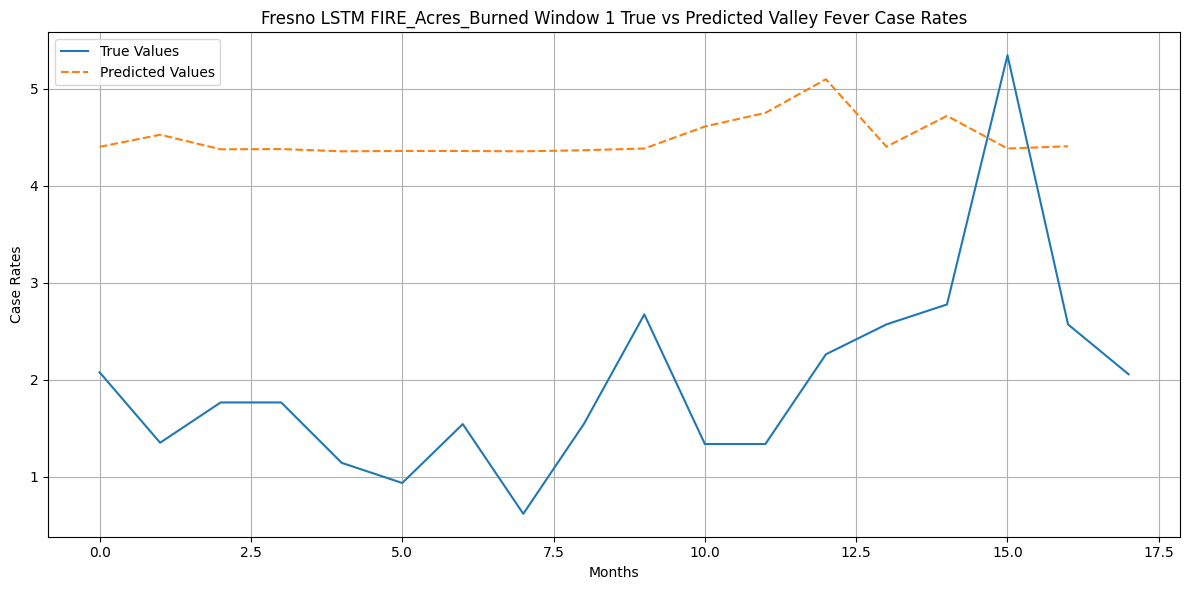

Epoch 1/300 - Training Loss 0.3633, Testing Loss 0.1193
Epoch 11/300 - Training Loss 0.2903, Testing Loss 0.0814
Epoch 21/300 - Training Loss 0.2303, Testing Loss 0.1551
Epoch 31/300 - Training Loss 0.2235, Testing Loss 0.2526
Epoch 41/300 - Training Loss 0.2169, Testing Loss 0.2186
Epoch 51/300 - Training Loss 0.2199, Testing Loss 0.1916
Epoch 61/300 - Training Loss 0.2160, Testing Loss 0.2052
Epoch 71/300 - Training Loss 0.2172, Testing Loss 0.2130
Epoch 81/300 - Training Loss 0.2165, Testing Loss 0.2047
Epoch 91/300 - Training Loss 0.2120, Testing Loss 0.2051
Epoch 101/300 - Training Loss 0.2128, Testing Loss 0.2039
Epoch 111/300 - Training Loss 0.2090, Testing Loss 0.1997
Epoch 121/300 - Training Loss 0.2082, Testing Loss 0.2004
Epoch 131/300 - Training Loss 0.2060, Testing Loss 0.1912
Epoch 141/300 - Training Loss 0.2031, Testing Loss 0.1912
Epoch 151/300 - Training Loss 0.2032, Testing Loss 0.1807
Epoch 161/300 - Training Loss 0.2059, Testing Loss 0.1766
Epoch 171/300 - Training 

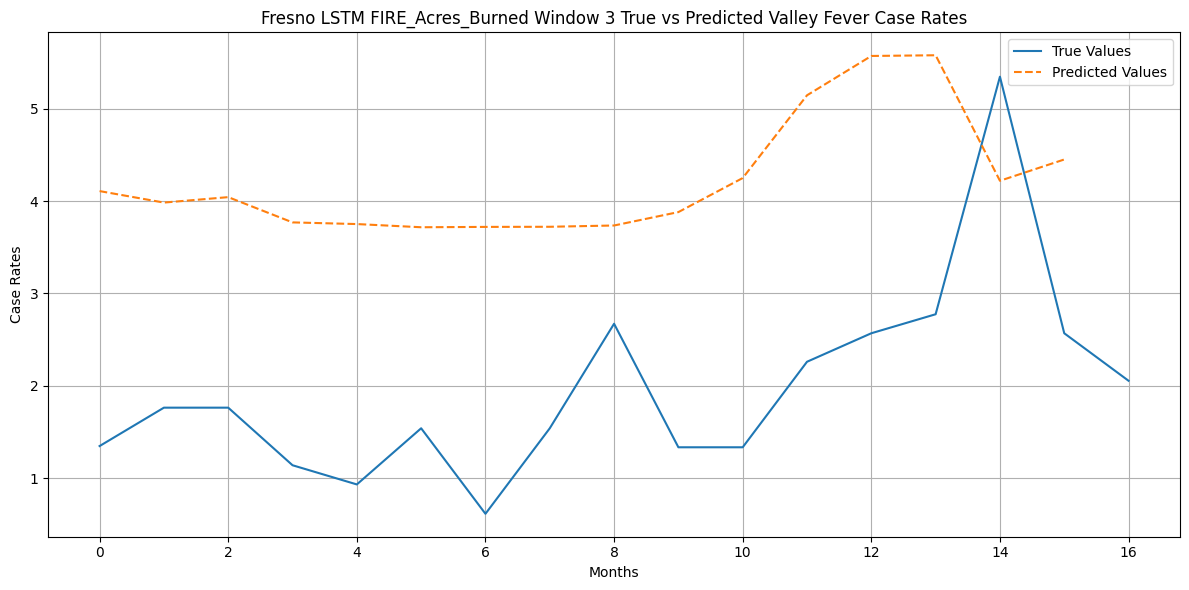

Epoch 1/300 - Training Loss 0.2647, Testing Loss 0.0989
Epoch 11/300 - Training Loss 0.2224, Testing Loss 0.1997
Epoch 21/300 - Training Loss 0.2244, Testing Loss 0.2330
Epoch 31/300 - Training Loss 0.2209, Testing Loss 0.1965
Epoch 41/300 - Training Loss 0.2214, Testing Loss 0.1964
Epoch 51/300 - Training Loss 0.2176, Testing Loss 0.2097
Epoch 61/300 - Training Loss 0.2172, Testing Loss 0.2009
Epoch 71/300 - Training Loss 0.2125, Testing Loss 0.1984
Epoch 81/300 - Training Loss 0.2039, Testing Loss 0.1847
Epoch 91/300 - Training Loss 0.1947, Testing Loss 0.1522
Epoch 101/300 - Training Loss 0.1917, Testing Loss 0.1451
Epoch 111/300 - Training Loss 0.1920, Testing Loss 0.1528
Epoch 121/300 - Training Loss 0.1864, Testing Loss 0.1459
Epoch 131/300 - Training Loss 0.1908, Testing Loss 0.1482
Epoch 141/300 - Training Loss 0.1860, Testing Loss 0.1367
Epoch 151/300 - Training Loss 0.1870, Testing Loss 0.1457
Epoch 161/300 - Training Loss 0.1871, Testing Loss 0.1437
Epoch 171/300 - Training 

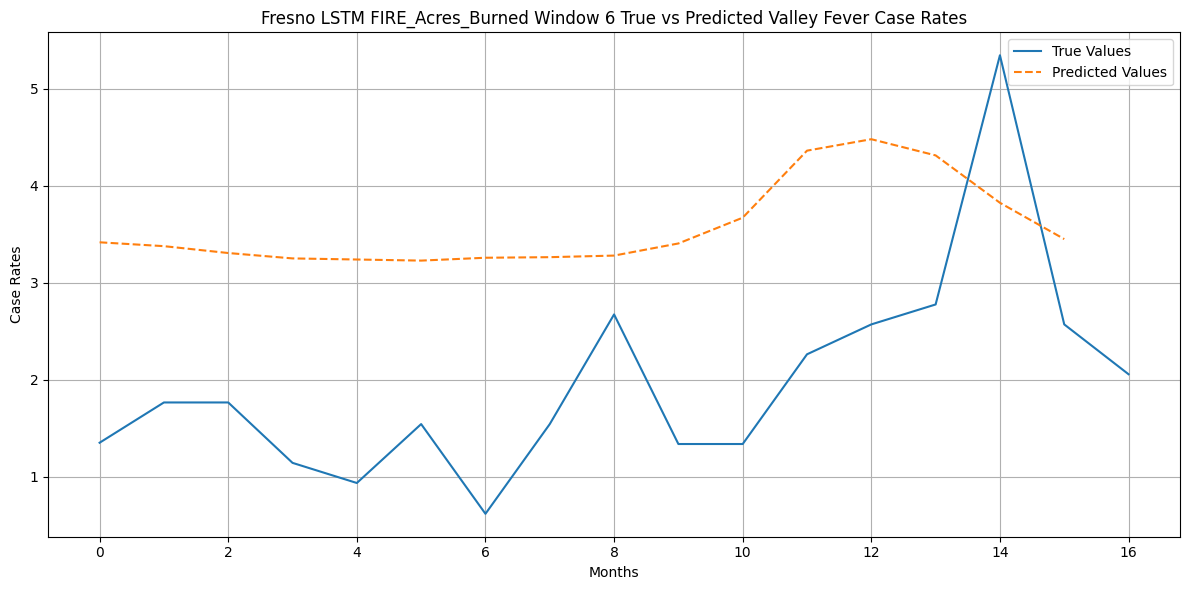

Epoch 1/300 - Training Loss 0.2390, Testing Loss 0.1389
Epoch 11/300 - Training Loss 0.2250, Testing Loss 0.2177
Epoch 21/300 - Training Loss 0.2240, Testing Loss 0.2015
Epoch 31/300 - Training Loss 0.2231, Testing Loss 0.1874
Epoch 41/300 - Training Loss 0.2204, Testing Loss 0.1987
Epoch 51/300 - Training Loss 0.2160, Testing Loss 0.1834
Epoch 61/300 - Training Loss 0.2064, Testing Loss 0.1702
Epoch 71/300 - Training Loss 0.1947, Testing Loss 0.1191
Epoch 81/300 - Training Loss 0.1943, Testing Loss 0.1229
Epoch 91/300 - Training Loss 0.1872, Testing Loss 0.1177
Epoch 101/300 - Training Loss 0.1756, Testing Loss 0.1075
Epoch 111/300 - Training Loss 0.1789, Testing Loss 0.1213
Epoch 121/300 - Training Loss 0.1736, Testing Loss 0.1183
Epoch 131/300 - Training Loss 0.1748, Testing Loss 0.1038
Epoch 141/300 - Training Loss 0.1716, Testing Loss 0.1193
Epoch 151/300 - Training Loss 0.1710, Testing Loss 0.1080
Epoch 161/300 - Training Loss 0.1635, Testing Loss 0.1043
Epoch 171/300 - Training 

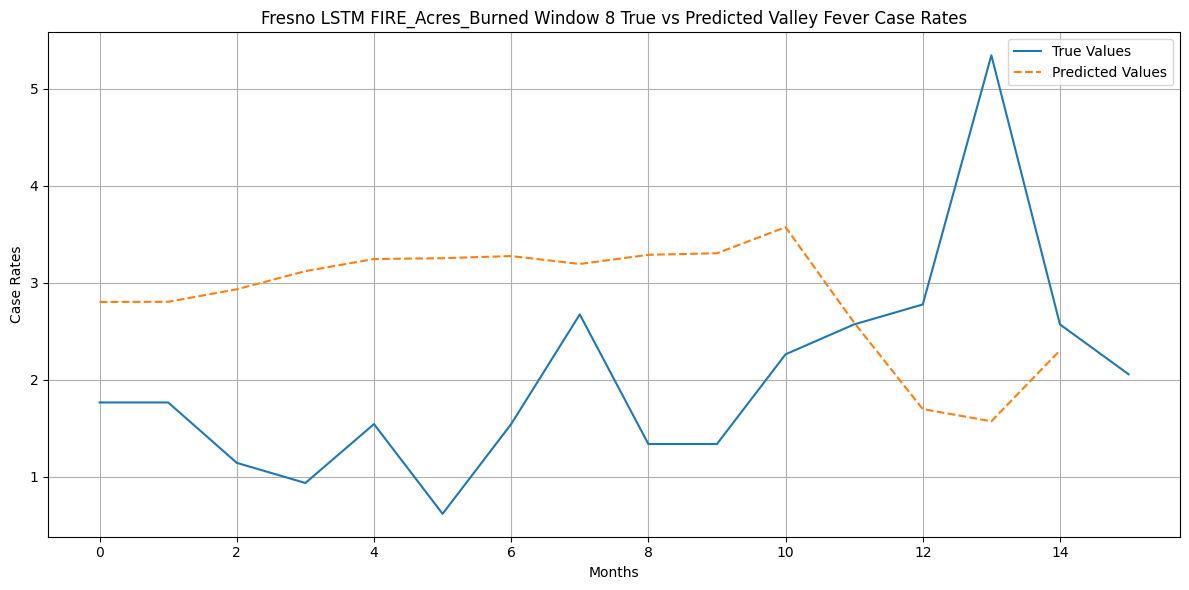

Epoch 1/300 - Training Loss 0.3690, Testing Loss 0.1265
Epoch 11/300 - Training Loss 0.2626, Testing Loss 0.1148
Epoch 21/300 - Training Loss 0.2448, Testing Loss 0.2606
Epoch 31/300 - Training Loss 0.2324, Testing Loss 0.1787
Epoch 41/300 - Training Loss 0.2329, Testing Loss 0.1795
Epoch 51/300 - Training Loss 0.2295, Testing Loss 0.2064
Epoch 61/300 - Training Loss 0.2276, Testing Loss 0.1896
Epoch 71/300 - Training Loss 0.2251, Testing Loss 0.1887
Epoch 81/300 - Training Loss 0.2238, Testing Loss 0.1889
Epoch 91/300 - Training Loss 0.2181, Testing Loss 0.1782
Epoch 101/300 - Training Loss 0.2147, Testing Loss 0.1663
Epoch 111/300 - Training Loss 0.2034, Testing Loss 0.1383
Epoch 121/300 - Training Loss 0.1912, Testing Loss 0.1131
Epoch 131/300 - Training Loss 0.1811, Testing Loss 0.1152
Epoch 141/300 - Training Loss 0.1813, Testing Loss 0.0936
Epoch 151/300 - Training Loss 0.1782, Testing Loss 0.0896
Epoch 161/300 - Training Loss 0.1715, Testing Loss 0.0927
Epoch 171/300 - Training 

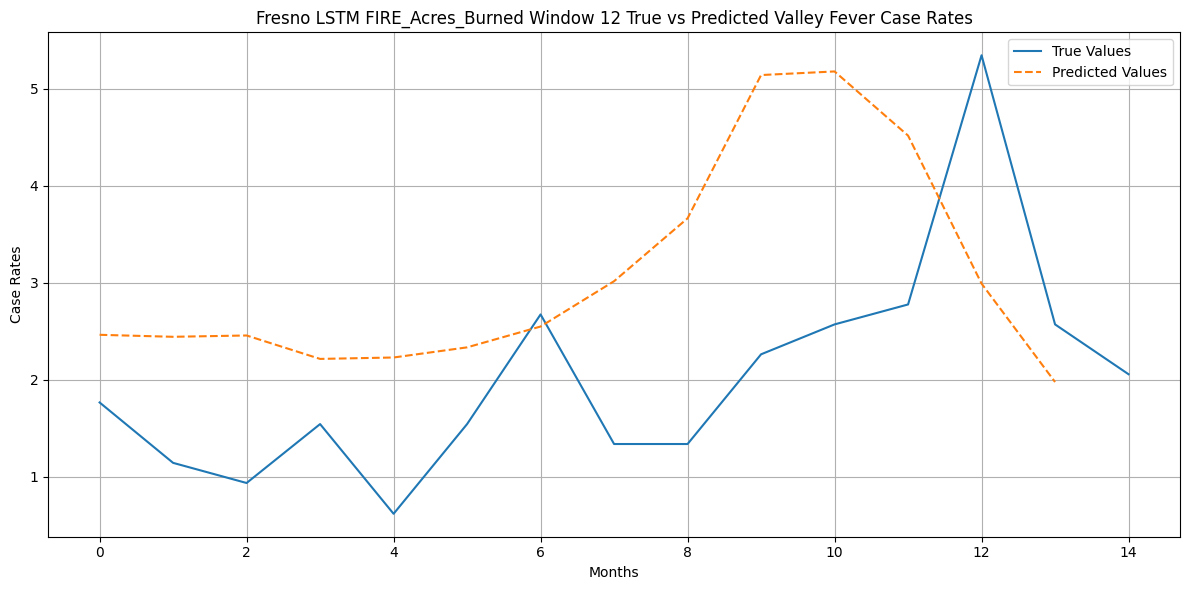

Epoch 1/300 - Training Loss 0.3514, Testing Loss 0.1090
Epoch 11/300 - Training Loss 0.3176, Testing Loss 0.0844
Epoch 21/300 - Training Loss 0.2841, Testing Loss 0.0799
Epoch 31/300 - Training Loss 0.2534, Testing Loss 0.1062
Epoch 41/300 - Training Loss 0.2269, Testing Loss 0.1564
Epoch 51/300 - Training Loss 0.2175, Testing Loss 0.2100
Epoch 61/300 - Training Loss 0.2193, Testing Loss 0.2315
Epoch 71/300 - Training Loss 0.2172, Testing Loss 0.2187
Epoch 81/300 - Training Loss 0.2153, Testing Loss 0.2060
Epoch 91/300 - Training Loss 0.2157, Testing Loss 0.2050
Epoch 101/300 - Training Loss 0.2183, Testing Loss 0.2090
Epoch 111/300 - Training Loss 0.2194, Testing Loss 0.2112
Epoch 121/300 - Training Loss 0.2150, Testing Loss 0.2107
Epoch 131/300 - Training Loss 0.2177, Testing Loss 0.2102
Epoch 141/300 - Training Loss 0.2171, Testing Loss 0.2099
Epoch 151/300 - Training Loss 0.2174, Testing Loss 0.2108
Epoch 161/300 - Training Loss 0.2171, Testing Loss 0.2110
Epoch 171/300 - Training 

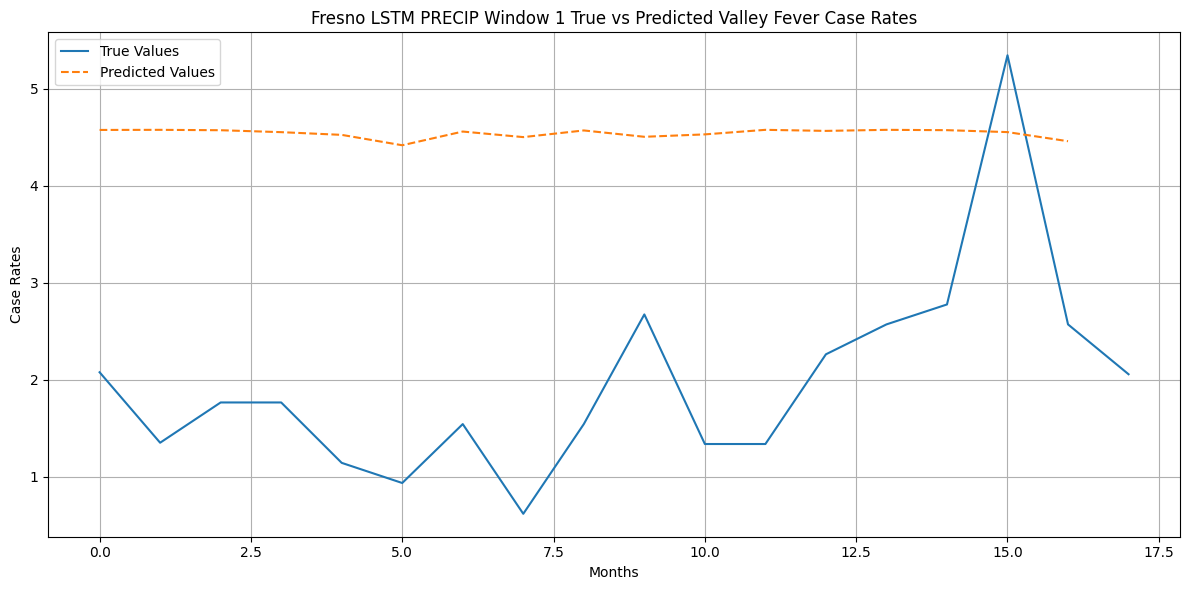

Epoch 1/300 - Training Loss 0.3100, Testing Loss 0.0824
Epoch 11/300 - Training Loss 0.2491, Testing Loss 0.1158
Epoch 21/300 - Training Loss 0.2181, Testing Loss 0.2036
Epoch 31/300 - Training Loss 0.2212, Testing Loss 0.2427
Epoch 41/300 - Training Loss 0.2191, Testing Loss 0.2104
Epoch 51/300 - Training Loss 0.2189, Testing Loss 0.1974
Epoch 61/300 - Training Loss 0.2176, Testing Loss 0.2073
Epoch 71/300 - Training Loss 0.2188, Testing Loss 0.2143
Epoch 81/300 - Training Loss 0.2175, Testing Loss 0.2098
Epoch 91/300 - Training Loss 0.2180, Testing Loss 0.2084
Epoch 101/300 - Training Loss 0.2183, Testing Loss 0.2114
Epoch 111/300 - Training Loss 0.2175, Testing Loss 0.2117
Epoch 121/300 - Training Loss 0.2173, Testing Loss 0.2116
Epoch 131/300 - Training Loss 0.2171, Testing Loss 0.2137
Epoch 141/300 - Training Loss 0.2176, Testing Loss 0.2121
Epoch 151/300 - Training Loss 0.2176, Testing Loss 0.2106
Epoch 161/300 - Training Loss 0.2176, Testing Loss 0.2140
Epoch 171/300 - Training 

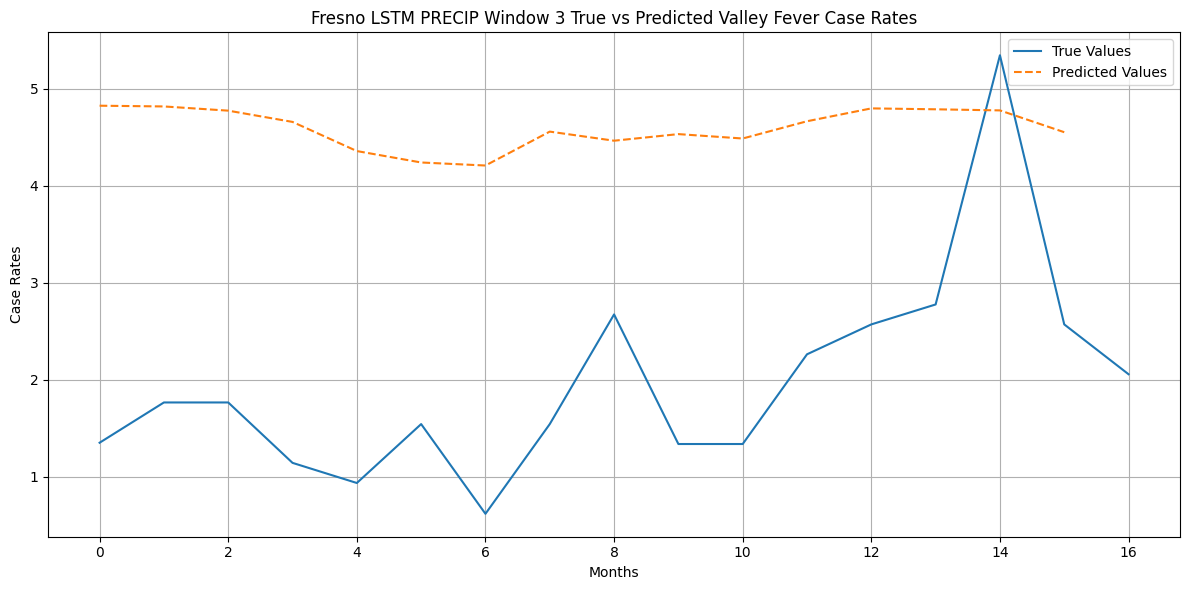

Epoch 1/300 - Training Loss 0.5652, Testing Loss 0.3264
Epoch 11/300 - Training Loss 0.4265, Testing Loss 0.1791
Epoch 21/300 - Training Loss 0.2549, Testing Loss 0.1278
Epoch 31/300 - Training Loss 0.2478, Testing Loss 0.2832
Epoch 41/300 - Training Loss 0.2246, Testing Loss 0.1619
Epoch 51/300 - Training Loss 0.2240, Testing Loss 0.1968
Epoch 61/300 - Training Loss 0.2226, Testing Loss 0.2177
Epoch 71/300 - Training Loss 0.2257, Testing Loss 0.1920
Epoch 81/300 - Training Loss 0.2209, Testing Loss 0.2060
Epoch 91/300 - Training Loss 0.2252, Testing Loss 0.2049
Epoch 101/300 - Training Loss 0.2232, Testing Loss 0.1998
Epoch 111/300 - Training Loss 0.2231, Testing Loss 0.2048
Epoch 121/300 - Training Loss 0.2244, Testing Loss 0.2016
Epoch 131/300 - Training Loss 0.2240, Testing Loss 0.2031
Epoch 141/300 - Training Loss 0.2202, Testing Loss 0.2036
Epoch 151/300 - Training Loss 0.2245, Testing Loss 0.2025
Epoch 161/300 - Training Loss 0.2246, Testing Loss 0.2039
Epoch 171/300 - Training 

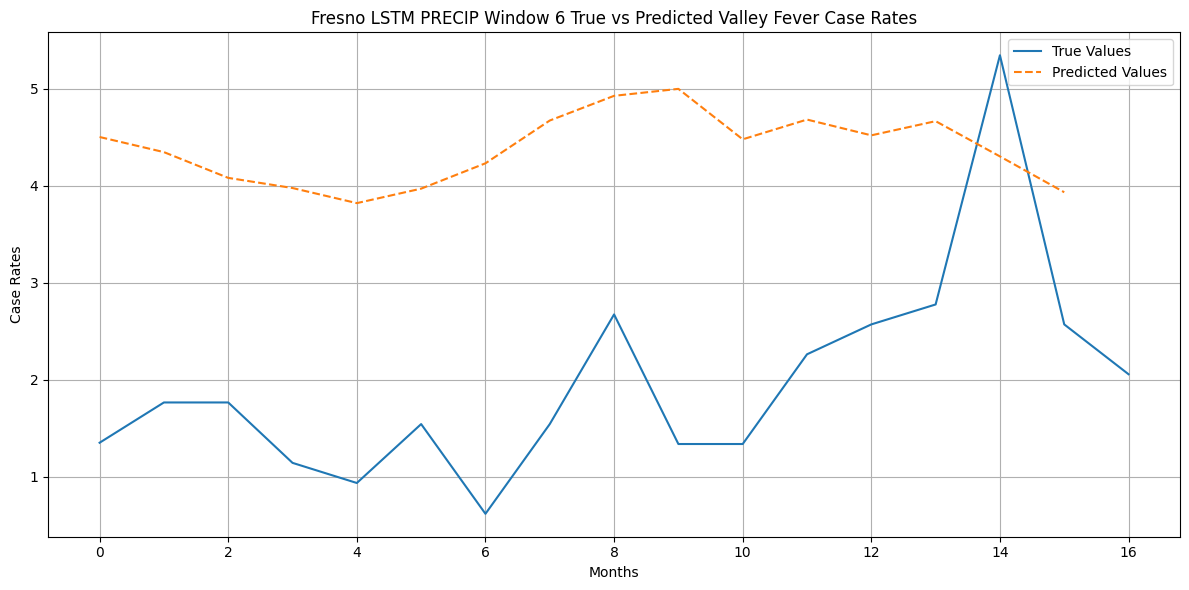

Epoch 1/300 - Training Loss 0.2953, Testing Loss 0.0823
Epoch 11/300 - Training Loss 0.2266, Testing Loss 0.1950
Epoch 21/300 - Training Loss 0.2283, Testing Loss 0.2289
Epoch 31/300 - Training Loss 0.2268, Testing Loss 0.1817
Epoch 41/300 - Training Loss 0.2249, Testing Loss 0.1927
Epoch 51/300 - Training Loss 0.2250, Testing Loss 0.2057
Epoch 61/300 - Training Loss 0.2244, Testing Loss 0.1949
Epoch 71/300 - Training Loss 0.2238, Testing Loss 0.1969
Epoch 81/300 - Training Loss 0.2231, Testing Loss 0.1985
Epoch 91/300 - Training Loss 0.2219, Testing Loss 0.1937
Epoch 101/300 - Training Loss 0.2165, Testing Loss 0.1879
Epoch 111/300 - Training Loss 0.2090, Testing Loss 0.1681
Epoch 121/300 - Training Loss 0.1995, Testing Loss 0.1556
Epoch 131/300 - Training Loss 0.1998, Testing Loss 0.1649
Epoch 141/300 - Training Loss 0.1973, Testing Loss 0.1699
Epoch 151/300 - Training Loss 0.1948, Testing Loss 0.1681
Epoch 161/300 - Training Loss 0.1943, Testing Loss 0.1787
Epoch 171/300 - Training 

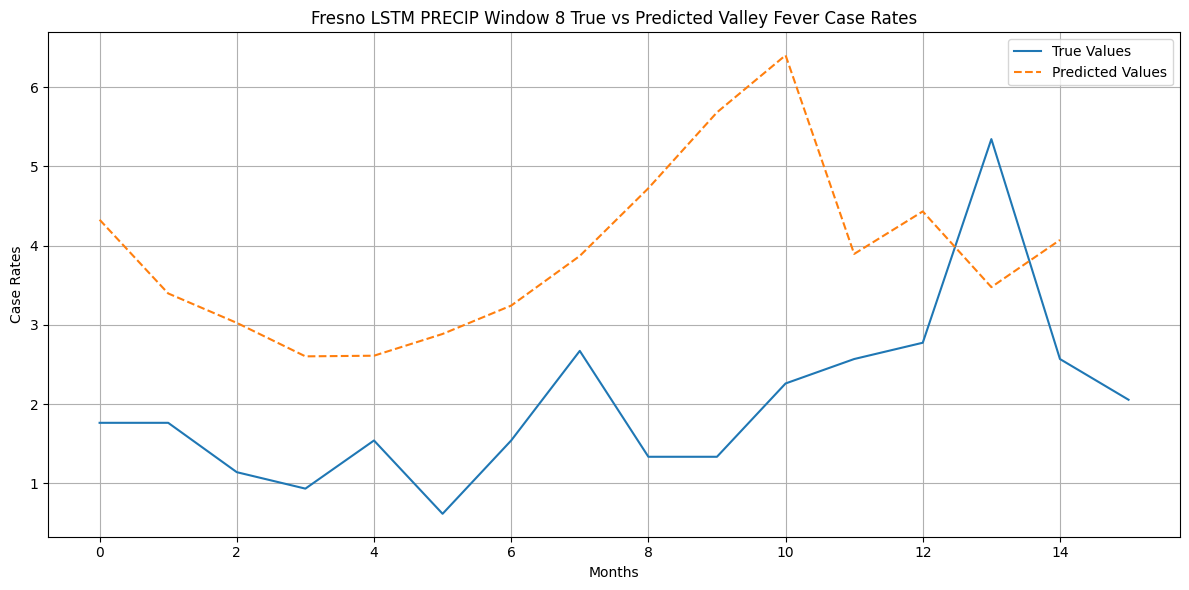

Epoch 1/300 - Training Loss 0.2706, Testing Loss 0.1016
Epoch 11/300 - Training Loss 0.2319, Testing Loss 0.2303
Epoch 21/300 - Training Loss 0.2320, Testing Loss 0.1997
Epoch 31/300 - Training Loss 0.2322, Testing Loss 0.1816
Epoch 41/300 - Training Loss 0.2314, Testing Loss 0.2026
Epoch 51/300 - Training Loss 0.2306, Testing Loss 0.1983
Epoch 61/300 - Training Loss 0.2303, Testing Loss 0.1931
Epoch 71/300 - Training Loss 0.2279, Testing Loss 0.1993
Epoch 81/300 - Training Loss 0.2213, Testing Loss 0.1905
Epoch 91/300 - Training Loss 0.1821, Testing Loss 0.1445
Epoch 101/300 - Training Loss 0.1605, Testing Loss 0.0732
Epoch 111/300 - Training Loss 0.1542, Testing Loss 0.1029
Epoch 121/300 - Training Loss 0.1516, Testing Loss 0.0736
Epoch 131/300 - Training Loss 0.1502, Testing Loss 0.0767
Epoch 141/300 - Training Loss 0.1481, Testing Loss 0.0702
Epoch 151/300 - Training Loss 0.1448, Testing Loss 0.0711
Epoch 161/300 - Training Loss 0.1414, Testing Loss 0.0708
Epoch 171/300 - Training 

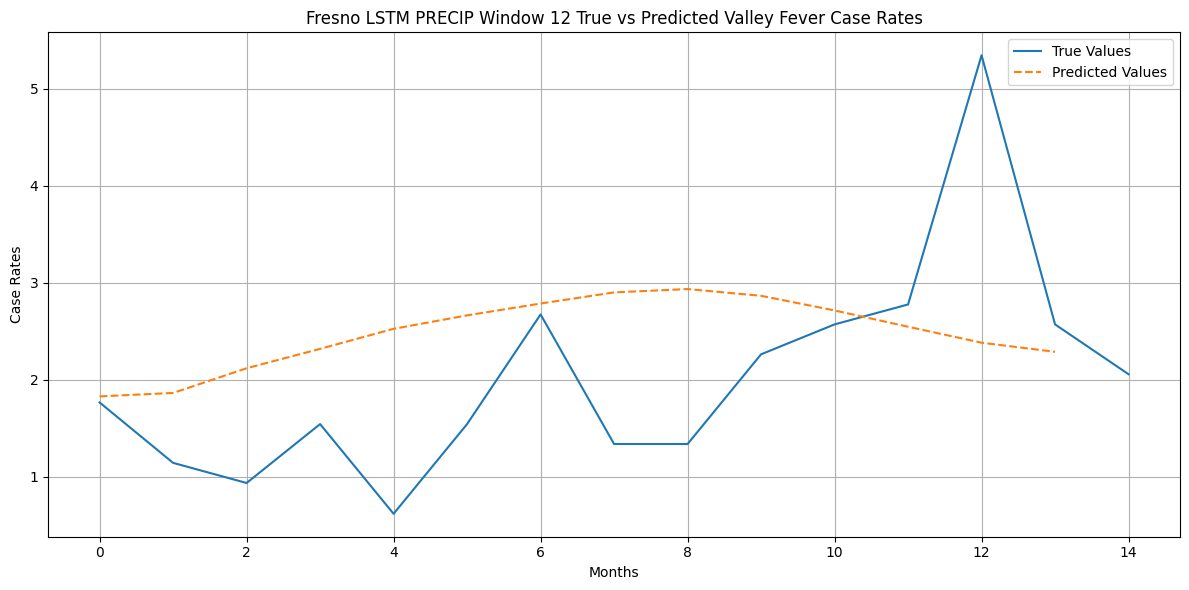

Epoch 1/300 - Training Loss 0.4645, Testing Loss 0.2241
Epoch 11/300 - Training Loss 0.4271, Testing Loss 0.1845
Epoch 21/300 - Training Loss 0.3880, Testing Loss 0.1434
Epoch 31/300 - Training Loss 0.3437, Testing Loss 0.1012
Epoch 41/300 - Training Loss 0.2926, Testing Loss 0.0783
Epoch 51/300 - Training Loss 0.2433, Testing Loss 0.1224
Epoch 61/300 - Training Loss 0.2182, Testing Loss 0.2032
Epoch 71/300 - Training Loss 0.2206, Testing Loss 0.2402
Epoch 81/300 - Training Loss 0.2194, Testing Loss 0.2196
Epoch 91/300 - Training Loss 0.2176, Testing Loss 0.2025
Epoch 101/300 - Training Loss 0.2175, Testing Loss 0.2050
Epoch 111/300 - Training Loss 0.2163, Testing Loss 0.2127
Epoch 121/300 - Training Loss 0.2147, Testing Loss 0.2151
Epoch 131/300 - Training Loss 0.2145, Testing Loss 0.2140
Epoch 141/300 - Training Loss 0.2155, Testing Loss 0.2134
Epoch 151/300 - Training Loss 0.2180, Testing Loss 0.2138
Epoch 161/300 - Training Loss 0.2167, Testing Loss 0.2154
Epoch 171/300 - Training 

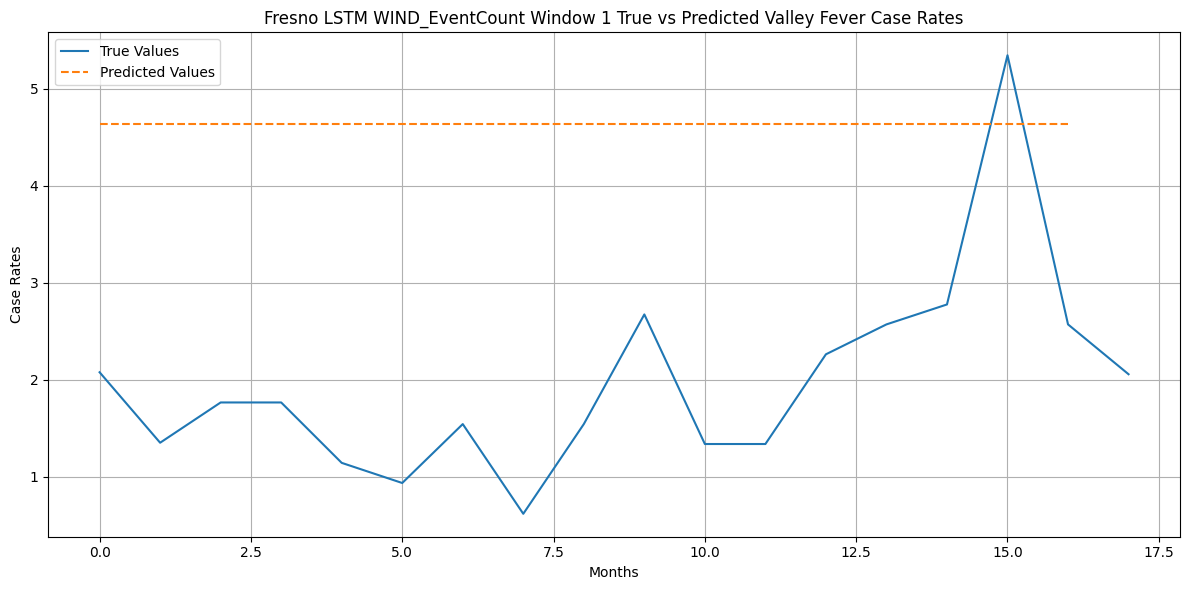

Epoch 1/300 - Training Loss 0.2241, Testing Loss 0.1754
Epoch 11/300 - Training Loss 0.2186, Testing Loss 0.2237
Epoch 21/300 - Training Loss 0.2187, Testing Loss 0.2006
Epoch 31/300 - Training Loss 0.2179, Testing Loss 0.2163
Epoch 41/300 - Training Loss 0.2180, Testing Loss 0.2108
Epoch 51/300 - Training Loss 0.2180, Testing Loss 0.2169
Epoch 61/300 - Training Loss 0.2174, Testing Loss 0.2151
Epoch 71/300 - Training Loss 0.2168, Testing Loss 0.2194
Epoch 81/300 - Training Loss 0.2172, Testing Loss 0.2197
Epoch 91/300 - Training Loss 0.2172, Testing Loss 0.2211
Epoch 101/300 - Training Loss 0.2170, Testing Loss 0.2228
Epoch 111/300 - Training Loss 0.2177, Testing Loss 0.2246
Epoch 121/300 - Training Loss 0.2163, Testing Loss 0.2225
Epoch 131/300 - Training Loss 0.2172, Testing Loss 0.2219
Epoch 141/300 - Training Loss 0.2169, Testing Loss 0.2231
Epoch 151/300 - Training Loss 0.2176, Testing Loss 0.2222
Epoch 161/300 - Training Loss 0.2173, Testing Loss 0.2218
Epoch 171/300 - Training 

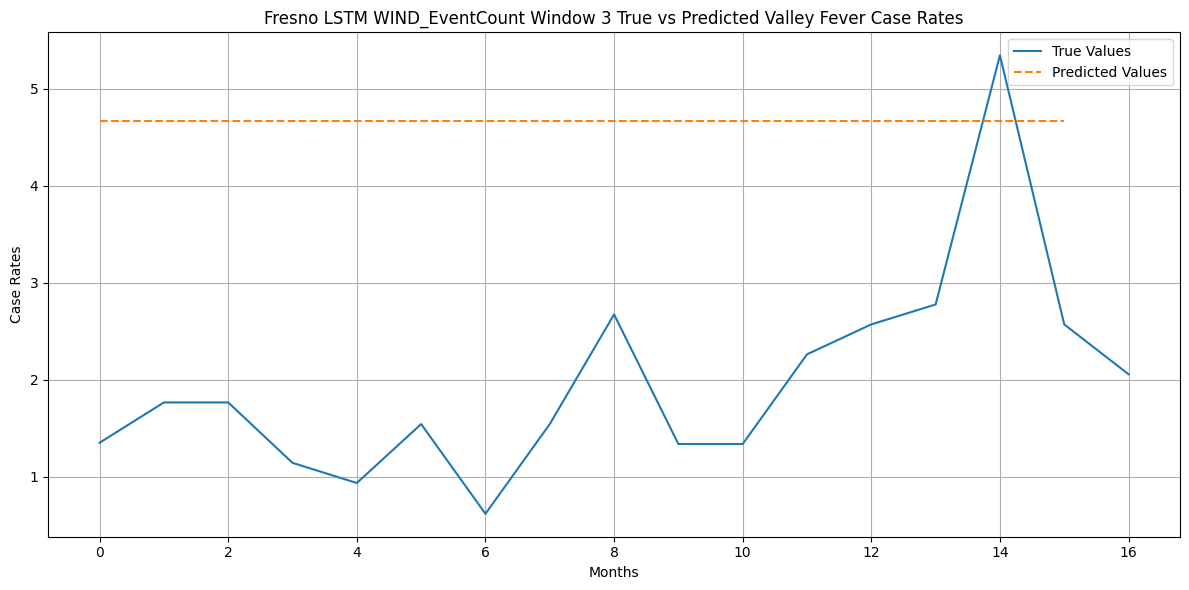

Epoch 1/300 - Training Loss 0.2992, Testing Loss 0.0804
Epoch 11/300 - Training Loss 0.2344, Testing Loss 0.1512
Epoch 21/300 - Training Loss 0.2268, Testing Loss 0.2424
Epoch 31/300 - Training Loss 0.2223, Testing Loss 0.2113
Epoch 41/300 - Training Loss 0.2239, Testing Loss 0.1918
Epoch 51/300 - Training Loss 0.2225, Testing Loss 0.2038
Epoch 61/300 - Training Loss 0.2239, Testing Loss 0.2116
Epoch 71/300 - Training Loss 0.2229, Testing Loss 0.2061
Epoch 81/300 - Training Loss 0.2211, Testing Loss 0.2051
Epoch 91/300 - Training Loss 0.2216, Testing Loss 0.2094
Epoch 101/300 - Training Loss 0.2221, Testing Loss 0.2093
Epoch 111/300 - Training Loss 0.2218, Testing Loss 0.2084
Epoch 121/300 - Training Loss 0.2217, Testing Loss 0.2096
Epoch 131/300 - Training Loss 0.2207, Testing Loss 0.2103
Epoch 141/300 - Training Loss 0.2209, Testing Loss 0.2101
Epoch 151/300 - Training Loss 0.2198, Testing Loss 0.2117
Epoch 161/300 - Training Loss 0.2224, Testing Loss 0.2128
Epoch 171/300 - Training 

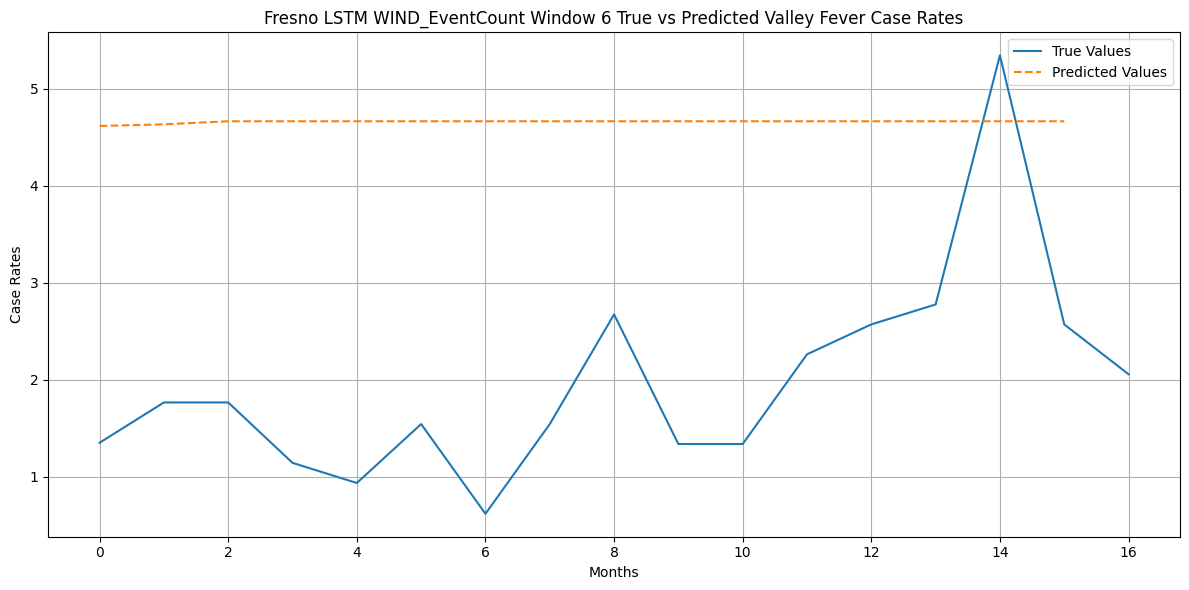

Epoch 1/300 - Training Loss 0.2896, Testing Loss 0.0828
Epoch 11/300 - Training Loss 0.2325, Testing Loss 0.1572
Epoch 21/300 - Training Loss 0.2284, Testing Loss 0.2314
Epoch 31/300 - Training Loss 0.2261, Testing Loss 0.2011
Epoch 41/300 - Training Loss 0.2260, Testing Loss 0.1866
Epoch 51/300 - Training Loss 0.2250, Testing Loss 0.1967
Epoch 61/300 - Training Loss 0.2251, Testing Loss 0.2033
Epoch 71/300 - Training Loss 0.2257, Testing Loss 0.1992
Epoch 81/300 - Training Loss 0.2253, Testing Loss 0.1981
Epoch 91/300 - Training Loss 0.2254, Testing Loss 0.2010
Epoch 101/300 - Training Loss 0.2262, Testing Loss 0.2008
Epoch 111/300 - Training Loss 0.2258, Testing Loss 0.2014
Epoch 121/300 - Training Loss 0.2249, Testing Loss 0.2024
Epoch 131/300 - Training Loss 0.2253, Testing Loss 0.2037
Epoch 141/300 - Training Loss 0.2260, Testing Loss 0.2043
Epoch 151/300 - Training Loss 0.2253, Testing Loss 0.2052
Epoch 161/300 - Training Loss 0.2249, Testing Loss 0.2066
Epoch 171/300 - Training 

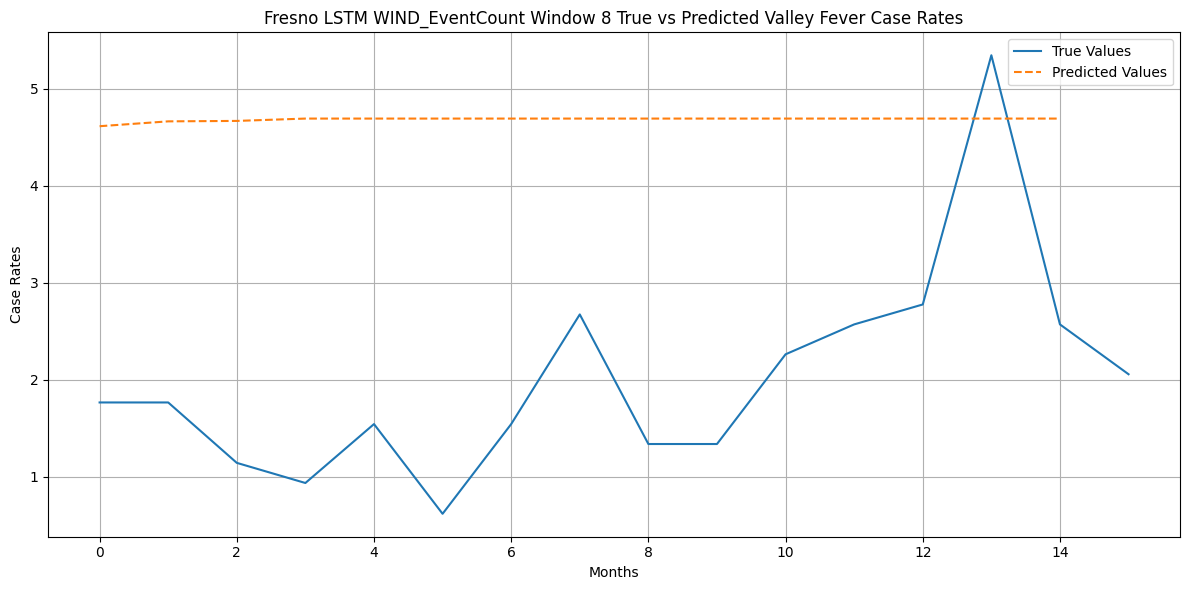

Epoch 1/300 - Training Loss 0.4925, Testing Loss 0.2556
Epoch 11/300 - Training Loss 0.3504, Testing Loss 0.1062
Epoch 21/300 - Training Loss 0.2426, Testing Loss 0.2723
Epoch 31/300 - Training Loss 0.2345, Testing Loss 0.1761
Epoch 41/300 - Training Loss 0.2375, Testing Loss 0.1658
Epoch 51/300 - Training Loss 0.2309, Testing Loss 0.2155
Epoch 61/300 - Training Loss 0.2300, Testing Loss 0.1876
Epoch 71/300 - Training Loss 0.2304, Testing Loss 0.1917
Epoch 81/300 - Training Loss 0.2309, Testing Loss 0.1989
Epoch 91/300 - Training Loss 0.2313, Testing Loss 0.1918
Epoch 101/300 - Training Loss 0.2337, Testing Loss 0.1966
Epoch 111/300 - Training Loss 0.2329, Testing Loss 0.1959
Epoch 121/300 - Training Loss 0.2326, Testing Loss 0.1966
Epoch 131/300 - Training Loss 0.2312, Testing Loss 0.1983
Epoch 141/300 - Training Loss 0.2310, Testing Loss 0.1972
Epoch 151/300 - Training Loss 0.2349, Testing Loss 0.1975
Epoch 161/300 - Training Loss 0.2333, Testing Loss 0.1976
Epoch 171/300 - Training 

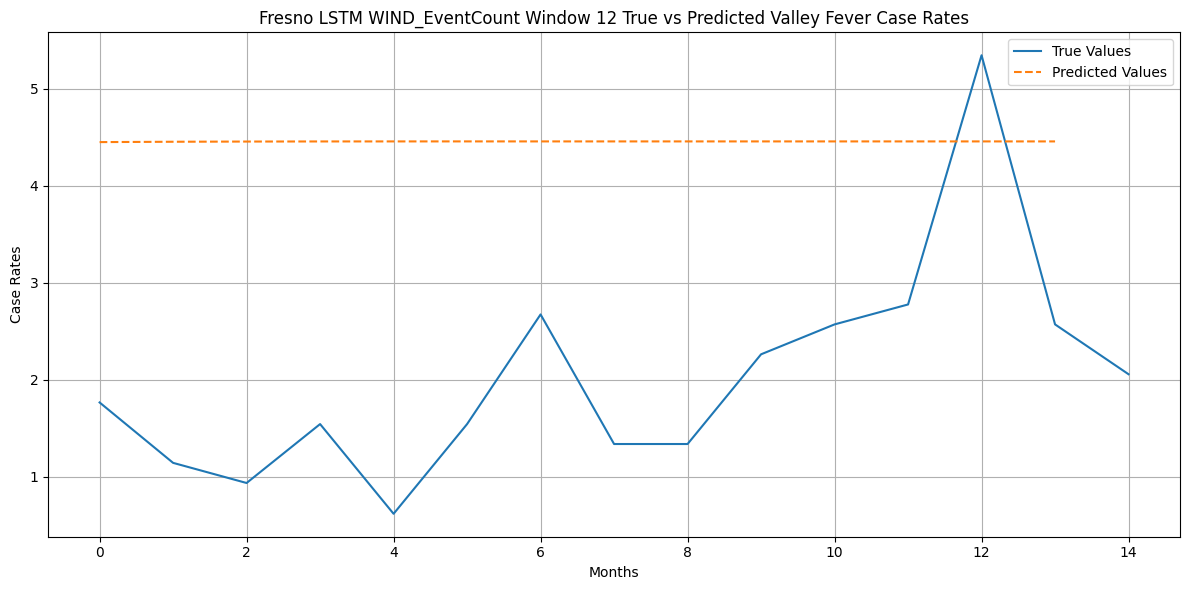

Epoch 1/300 - Training Loss 0.4353, Testing Loss 0.1934
Epoch 11/300 - Training Loss 0.3964, Testing Loss 0.1533
Epoch 21/300 - Training Loss 0.3572, Testing Loss 0.1139
Epoch 31/300 - Training Loss 0.3142, Testing Loss 0.0817
Epoch 41/300 - Training Loss 0.2666, Testing Loss 0.0908
Epoch 51/300 - Training Loss 0.2271, Testing Loss 0.1558
Epoch 61/300 - Training Loss 0.2163, Testing Loss 0.2251
Epoch 71/300 - Training Loss 0.2178, Testing Loss 0.2322
Epoch 81/300 - Training Loss 0.2176, Testing Loss 0.2074
Epoch 91/300 - Training Loss 0.2174, Testing Loss 0.1989
Epoch 101/300 - Training Loss 0.2167, Testing Loss 0.2059
Epoch 111/300 - Training Loss 0.2168, Testing Loss 0.2100
Epoch 121/300 - Training Loss 0.2216, Testing Loss 0.2098
Epoch 131/300 - Training Loss 0.2178, Testing Loss 0.2083
Epoch 141/300 - Training Loss 0.2177, Testing Loss 0.2075
Epoch 151/300 - Training Loss 0.2148, Testing Loss 0.2095
Epoch 161/300 - Training Loss 0.2195, Testing Loss 0.2106
Epoch 171/300 - Training 

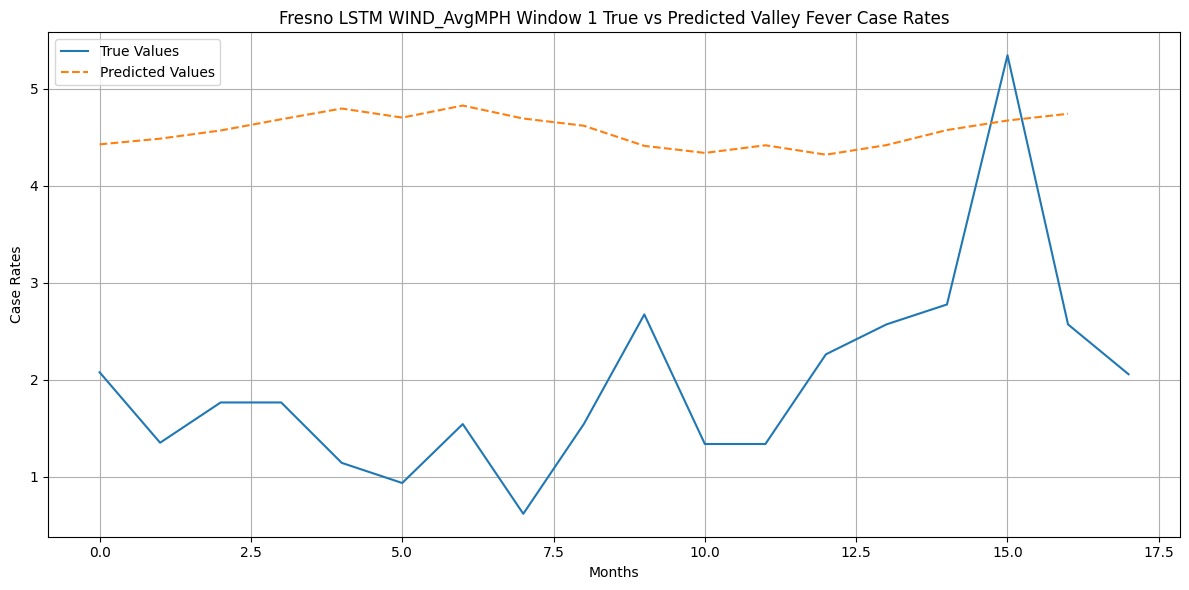

Epoch 1/300 - Training Loss 0.4643, Testing Loss 0.2222
Epoch 11/300 - Training Loss 0.3814, Testing Loss 0.1366
Epoch 21/300 - Training Loss 0.3015, Testing Loss 0.0807
Epoch 31/300 - Training Loss 0.2277, Testing Loss 0.1590
Epoch 41/300 - Training Loss 0.2262, Testing Loss 0.2632
Epoch 51/300 - Training Loss 0.2186, Testing Loss 0.2130
Epoch 61/300 - Training Loss 0.2206, Testing Loss 0.1885
Epoch 71/300 - Training Loss 0.2199, Testing Loss 0.2069
Epoch 81/300 - Training Loss 0.2186, Testing Loss 0.2156
Epoch 91/300 - Training Loss 0.2195, Testing Loss 0.2061
Epoch 101/300 - Training Loss 0.2185, Testing Loss 0.2050
Epoch 111/300 - Training Loss 0.2203, Testing Loss 0.2094
Epoch 121/300 - Training Loss 0.2190, Testing Loss 0.2076
Epoch 131/300 - Training Loss 0.2179, Testing Loss 0.2068
Epoch 141/300 - Training Loss 0.2174, Testing Loss 0.2082
Epoch 151/300 - Training Loss 0.2189, Testing Loss 0.2079
Epoch 161/300 - Training Loss 0.2190, Testing Loss 0.2071
Epoch 171/300 - Training 

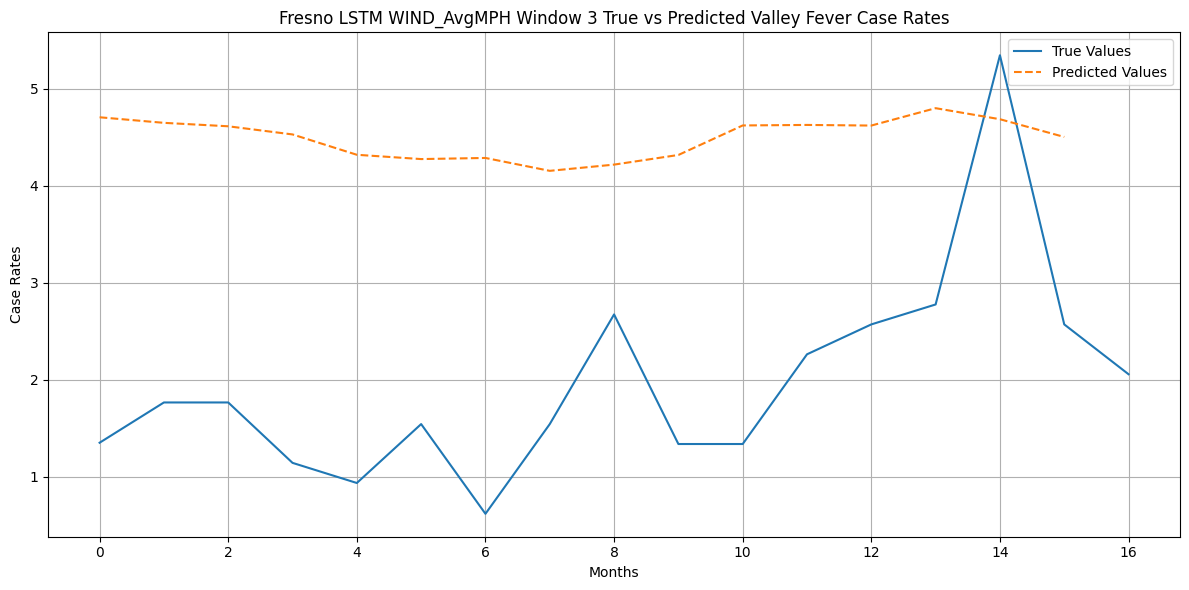

Epoch 1/300 - Training Loss 0.4445, Testing Loss 0.1974
Epoch 11/300 - Training Loss 0.3160, Testing Loss 0.0820
Epoch 21/300 - Training Loss 0.2215, Testing Loss 0.2151
Epoch 31/300 - Training Loss 0.2293, Testing Loss 0.2425
Epoch 41/300 - Training Loss 0.2206, Testing Loss 0.1756
Epoch 51/300 - Training Loss 0.2202, Testing Loss 0.2032
Epoch 61/300 - Training Loss 0.2204, Testing Loss 0.2157
Epoch 71/300 - Training Loss 0.2188, Testing Loss 0.1982
Epoch 81/300 - Training Loss 0.2197, Testing Loss 0.2058
Epoch 91/300 - Training Loss 0.2206, Testing Loss 0.2049
Epoch 101/300 - Training Loss 0.2203, Testing Loss 0.2030
Epoch 111/300 - Training Loss 0.2195, Testing Loss 0.2060
Epoch 121/300 - Training Loss 0.2140, Testing Loss 0.2029
Epoch 131/300 - Training Loss 0.2170, Testing Loss 0.1993
Epoch 141/300 - Training Loss 0.2173, Testing Loss 0.2060
Epoch 151/300 - Training Loss 0.2133, Testing Loss 0.2100
Epoch 161/300 - Training Loss 0.2142, Testing Loss 0.2083
Epoch 171/300 - Training 

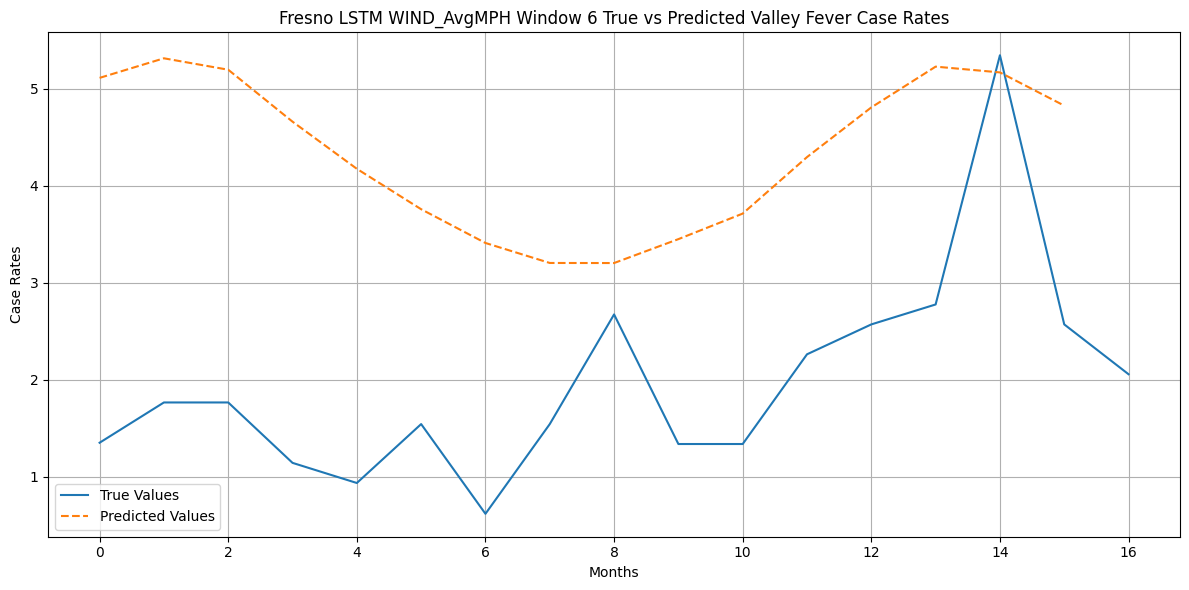

Epoch 1/300 - Training Loss 0.4023, Testing Loss 0.1626
Epoch 11/300 - Training Loss 0.3190, Testing Loss 0.0880
Epoch 21/300 - Training Loss 0.2415, Testing Loss 0.1391
Epoch 31/300 - Training Loss 0.2316, Testing Loss 0.2520
Epoch 41/300 - Training Loss 0.2261, Testing Loss 0.1751
Epoch 51/300 - Training Loss 0.2243, Testing Loss 0.1859
Epoch 61/300 - Training Loss 0.2216, Testing Loss 0.2099
Epoch 71/300 - Training Loss 0.2240, Testing Loss 0.1922
Epoch 81/300 - Training Loss 0.2240, Testing Loss 0.1956
Epoch 91/300 - Training Loss 0.2249, Testing Loss 0.1971
Epoch 101/300 - Training Loss 0.2219, Testing Loss 0.1940
Epoch 111/300 - Training Loss 0.2260, Testing Loss 0.1979
Epoch 121/300 - Training Loss 0.2209, Testing Loss 0.1920
Epoch 131/300 - Training Loss 0.2217, Testing Loss 0.1983
Epoch 141/300 - Training Loss 0.2207, Testing Loss 0.1916
Epoch 151/300 - Training Loss 0.2189, Testing Loss 0.1917
Epoch 161/300 - Training Loss 0.2165, Testing Loss 0.1854
Epoch 171/300 - Training 

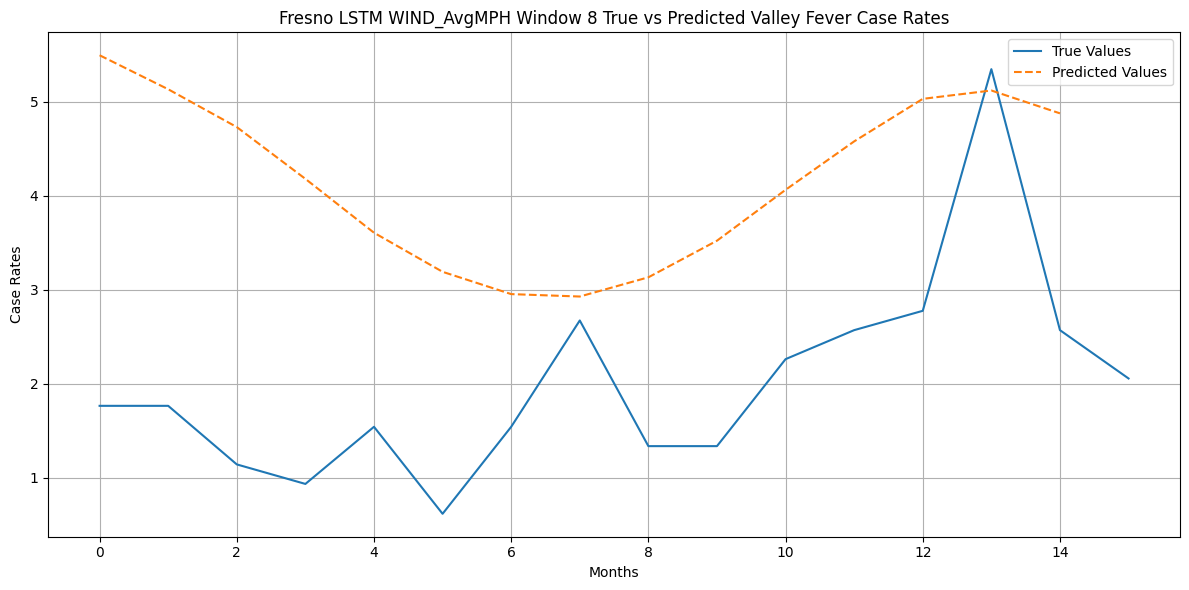

Epoch 1/300 - Training Loss 0.4238, Testing Loss 0.1816
Epoch 11/300 - Training Loss 0.3137, Testing Loss 0.0860
Epoch 21/300 - Training Loss 0.2368, Testing Loss 0.1759
Epoch 31/300 - Training Loss 0.2412, Testing Loss 0.2375
Epoch 41/300 - Training Loss 0.2339, Testing Loss 0.1752
Epoch 51/300 - Training Loss 0.2328, Testing Loss 0.1856
Epoch 61/300 - Training Loss 0.2328, Testing Loss 0.2051
Epoch 71/300 - Training Loss 0.2311, Testing Loss 0.1947
Epoch 81/300 - Training Loss 0.2294, Testing Loss 0.1913
Epoch 91/300 - Training Loss 0.2322, Testing Loss 0.1964
Epoch 101/300 - Training Loss 0.2280, Testing Loss 0.1933
Epoch 111/300 - Training Loss 0.2292, Testing Loss 0.1929
Epoch 121/300 - Training Loss 0.2296, Testing Loss 0.1923
Epoch 131/300 - Training Loss 0.2286, Testing Loss 0.1876
Epoch 141/300 - Training Loss 0.2286, Testing Loss 0.1836
Epoch 151/300 - Training Loss 0.2253, Testing Loss 0.1828
Epoch 161/300 - Training Loss 0.2236, Testing Loss 0.1836
Epoch 171/300 - Training 

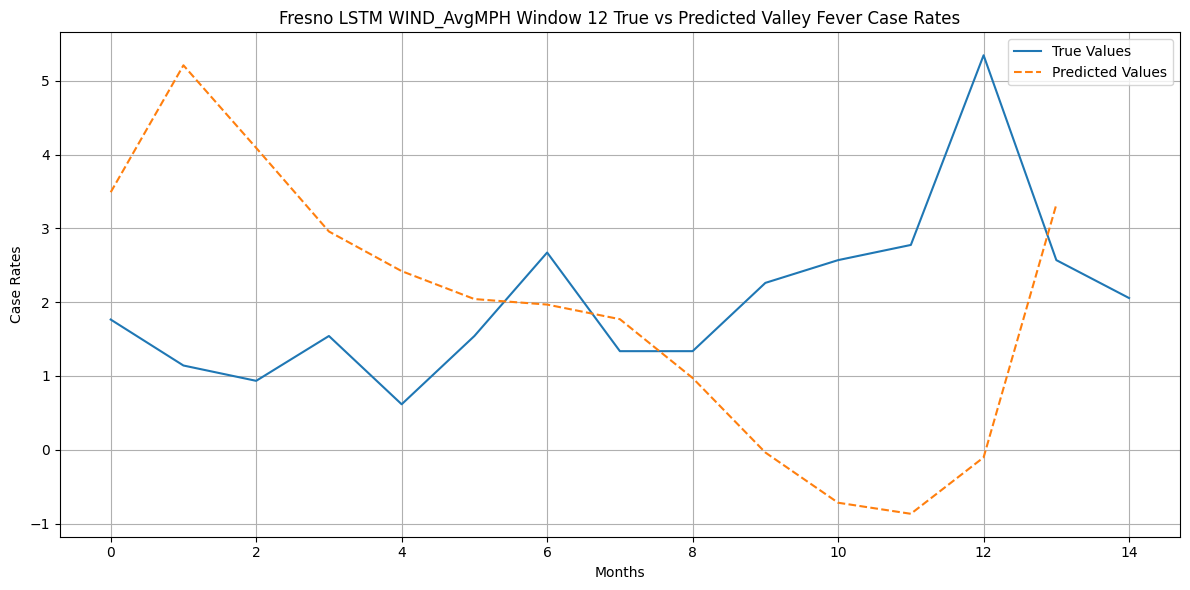

Epoch 1/300 - Training Loss 0.4079, Testing Loss 0.1645
Epoch 11/300 - Training Loss 0.3697, Testing Loss 0.1254
Epoch 21/300 - Training Loss 0.3294, Testing Loss 0.0906
Epoch 31/300 - Training Loss 0.2876, Testing Loss 0.0782
Epoch 41/300 - Training Loss 0.2445, Testing Loss 0.1156
Epoch 51/300 - Training Loss 0.2227, Testing Loss 0.1829
Epoch 61/300 - Training Loss 0.2176, Testing Loss 0.2286
Epoch 71/300 - Training Loss 0.2219, Testing Loss 0.2209
Epoch 81/300 - Training Loss 0.2194, Testing Loss 0.2019
Epoch 91/300 - Training Loss 0.2207, Testing Loss 0.1978
Epoch 101/300 - Training Loss 0.2204, Testing Loss 0.2040
Epoch 111/300 - Training Loss 0.2235, Testing Loss 0.2073
Epoch 121/300 - Training Loss 0.2184, Testing Loss 0.2073
Epoch 131/300 - Training Loss 0.2224, Testing Loss 0.2062
Epoch 141/300 - Training Loss 0.2180, Testing Loss 0.2068
Epoch 151/300 - Training Loss 0.2183, Testing Loss 0.2080
Epoch 161/300 - Training Loss 0.2196, Testing Loss 0.2085
Epoch 171/300 - Training 

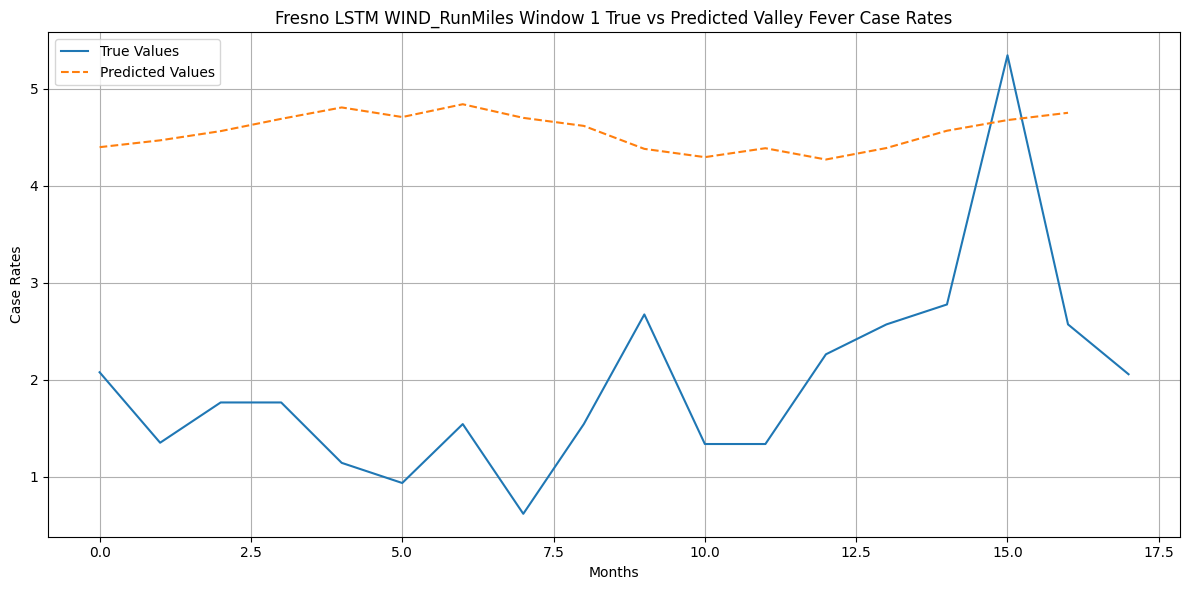

Epoch 1/300 - Training Loss 0.3320, Testing Loss 0.0935
Epoch 11/300 - Training Loss 0.2619, Testing Loss 0.1008
Epoch 21/300 - Training Loss 0.2189, Testing Loss 0.2128
Epoch 31/300 - Training Loss 0.2226, Testing Loss 0.2437
Epoch 41/300 - Training Loss 0.2177, Testing Loss 0.1961
Epoch 51/300 - Training Loss 0.2179, Testing Loss 0.1961
Epoch 61/300 - Training Loss 0.2174, Testing Loss 0.2134
Epoch 71/300 - Training Loss 0.2172, Testing Loss 0.2105
Epoch 81/300 - Training Loss 0.2177, Testing Loss 0.2042
Epoch 91/300 - Training Loss 0.2183, Testing Loss 0.2079
Epoch 101/300 - Training Loss 0.2177, Testing Loss 0.2093
Epoch 111/300 - Training Loss 0.2194, Testing Loss 0.2076
Epoch 121/300 - Training Loss 0.2190, Testing Loss 0.2068
Epoch 131/300 - Training Loss 0.2204, Testing Loss 0.2086
Epoch 141/300 - Training Loss 0.2196, Testing Loss 0.2064
Epoch 151/300 - Training Loss 0.2187, Testing Loss 0.2079
Epoch 161/300 - Training Loss 0.2177, Testing Loss 0.2092
Epoch 171/300 - Training 

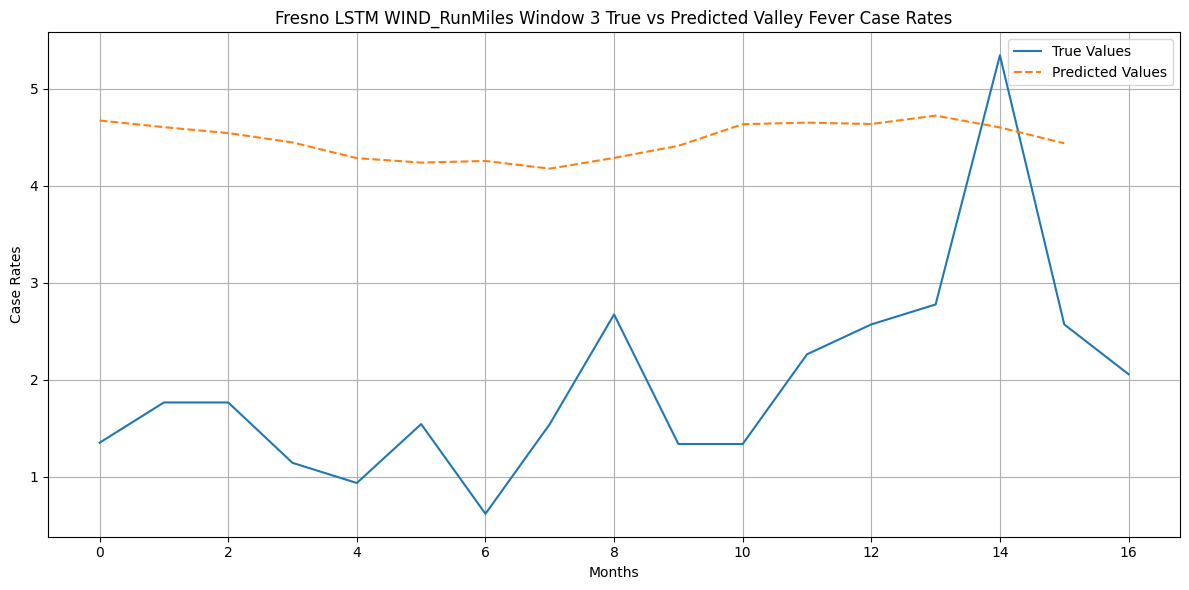

Epoch 1/300 - Training Loss 0.3277, Testing Loss 0.0897
Epoch 11/300 - Training Loss 0.2498, Testing Loss 0.1176
Epoch 21/300 - Training Loss 0.2231, Testing Loss 0.2338
Epoch 31/300 - Training Loss 0.2237, Testing Loss 0.2245
Epoch 41/300 - Training Loss 0.2221, Testing Loss 0.1897
Epoch 51/300 - Training Loss 0.2222, Testing Loss 0.1996
Epoch 61/300 - Training Loss 0.2209, Testing Loss 0.2119
Epoch 71/300 - Training Loss 0.2207, Testing Loss 0.2052
Epoch 81/300 - Training Loss 0.2197, Testing Loss 0.2043
Epoch 91/300 - Training Loss 0.2184, Testing Loss 0.2080
Epoch 101/300 - Training Loss 0.2161, Testing Loss 0.2046
Epoch 111/300 - Training Loss 0.2174, Testing Loss 0.2062
Epoch 121/300 - Training Loss 0.2124, Testing Loss 0.2022
Epoch 131/300 - Training Loss 0.2153, Testing Loss 0.2019
Epoch 141/300 - Training Loss 0.2147, Testing Loss 0.1980
Epoch 151/300 - Training Loss 0.2135, Testing Loss 0.2025
Epoch 161/300 - Training Loss 0.2136, Testing Loss 0.2027
Epoch 171/300 - Training 

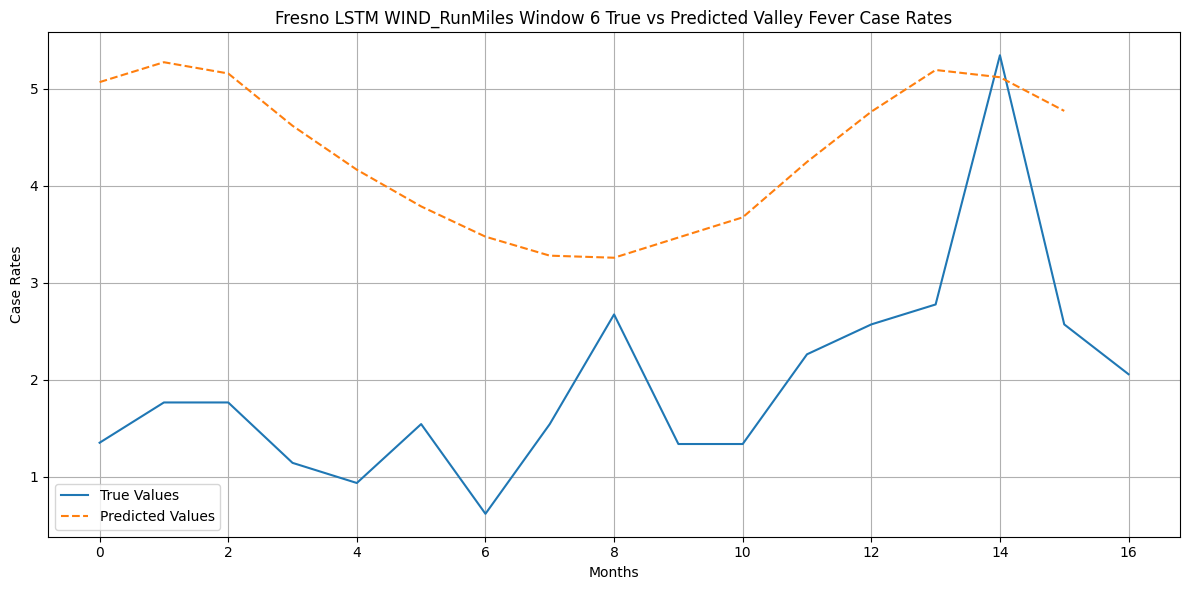

Epoch 1/300 - Training Loss 0.3059, Testing Loss 0.0831
Epoch 11/300 - Training Loss 0.2344, Testing Loss 0.1553
Epoch 21/300 - Training Loss 0.2300, Testing Loss 0.2424
Epoch 31/300 - Training Loss 0.2243, Testing Loss 0.1904
Epoch 41/300 - Training Loss 0.2253, Testing Loss 0.1841
Epoch 51/300 - Training Loss 0.2245, Testing Loss 0.2033
Epoch 61/300 - Training Loss 0.2248, Testing Loss 0.2009
Epoch 71/300 - Training Loss 0.2233, Testing Loss 0.1934
Epoch 81/300 - Training Loss 0.2226, Testing Loss 0.1990
Epoch 91/300 - Training Loss 0.2208, Testing Loss 0.1943
Epoch 101/300 - Training Loss 0.2198, Testing Loss 0.1959
Epoch 111/300 - Training Loss 0.2175, Testing Loss 0.1957
Epoch 121/300 - Training Loss 0.2188, Testing Loss 0.1889
Epoch 131/300 - Training Loss 0.2171, Testing Loss 0.1911
Epoch 141/300 - Training Loss 0.2189, Testing Loss 0.1947
Epoch 151/300 - Training Loss 0.2147, Testing Loss 0.1896
Epoch 161/300 - Training Loss 0.2176, Testing Loss 0.1903
Epoch 171/300 - Training 

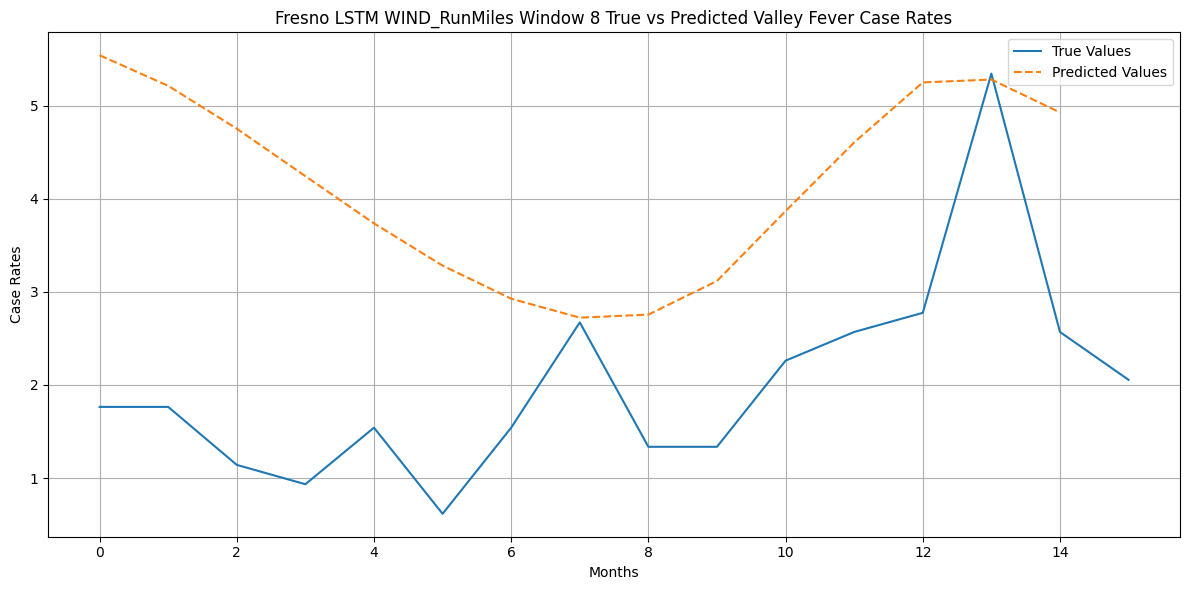

Epoch 1/300 - Training Loss 0.3543, Testing Loss 0.1129
Epoch 11/300 - Training Loss 0.2538, Testing Loss 0.1256
Epoch 21/300 - Training Loss 0.2411, Testing Loss 0.2542
Epoch 31/300 - Training Loss 0.2311, Testing Loss 0.1838
Epoch 41/300 - Training Loss 0.2331, Testing Loss 0.1804
Epoch 51/300 - Training Loss 0.2315, Testing Loss 0.2044
Epoch 61/300 - Training Loss 0.2315, Testing Loss 0.1960
Epoch 71/300 - Training Loss 0.2322, Testing Loss 0.1918
Epoch 81/300 - Training Loss 0.2305, Testing Loss 0.1977
Epoch 91/300 - Training Loss 0.2302, Testing Loss 0.1930
Epoch 101/300 - Training Loss 0.2292, Testing Loss 0.1944
Epoch 111/300 - Training Loss 0.2295, Testing Loss 0.1933
Epoch 121/300 - Training Loss 0.2301, Testing Loss 0.1915
Epoch 131/300 - Training Loss 0.2285, Testing Loss 0.1908
Epoch 141/300 - Training Loss 0.2273, Testing Loss 0.1874
Epoch 151/300 - Training Loss 0.2280, Testing Loss 0.1837
Epoch 161/300 - Training Loss 0.2250, Testing Loss 0.1785
Epoch 171/300 - Training 

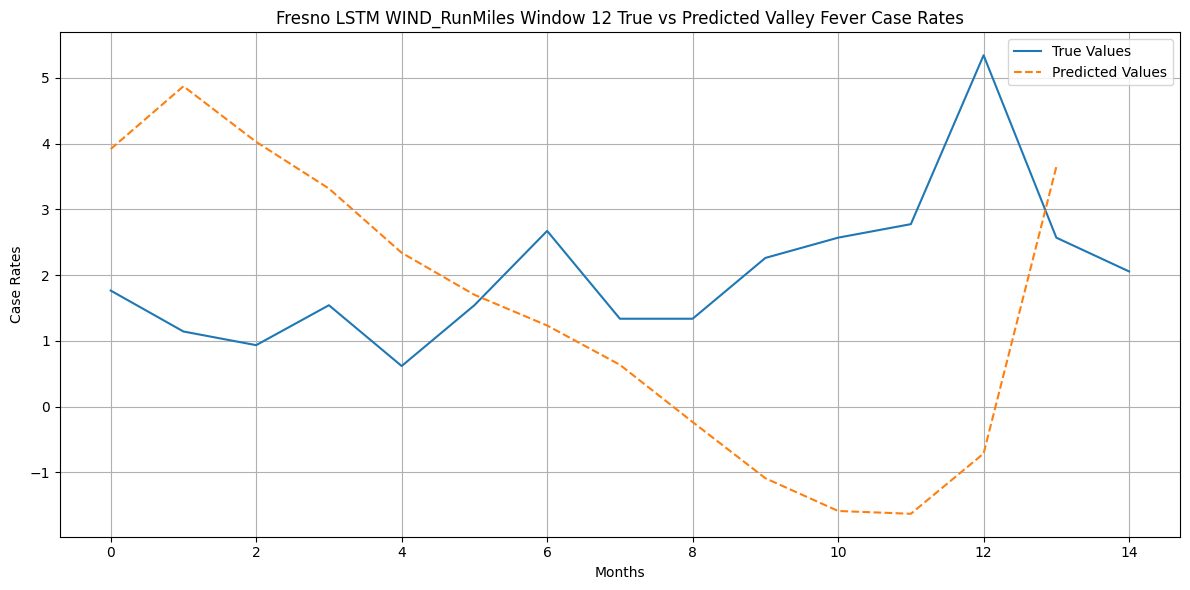

Epoch 1/300 - Training Loss 0.5106, Testing Loss 0.2729
Epoch 11/300 - Training Loss 0.4667, Testing Loss 0.2263
Epoch 21/300 - Training Loss 0.4208, Testing Loss 0.1771
Epoch 31/300 - Training Loss 0.3687, Testing Loss 0.1237
Epoch 41/300 - Training Loss 0.3093, Testing Loss 0.0804
Epoch 51/300 - Training Loss 0.2460, Testing Loss 0.1149
Epoch 61/300 - Training Loss 0.2154, Testing Loss 0.2060
Epoch 71/300 - Training Loss 0.2197, Testing Loss 0.2466
Epoch 81/300 - Training Loss 0.2201, Testing Loss 0.2202
Epoch 91/300 - Training Loss 0.2160, Testing Loss 0.1992
Epoch 101/300 - Training Loss 0.2173, Testing Loss 0.2017
Epoch 111/300 - Training Loss 0.2102, Testing Loss 0.2101
Epoch 121/300 - Training Loss 0.2172, Testing Loss 0.2123
Epoch 131/300 - Training Loss 0.2215, Testing Loss 0.2073
Epoch 141/300 - Training Loss 0.2168, Testing Loss 0.2065
Epoch 151/300 - Training Loss 0.2180, Testing Loss 0.2098
Epoch 161/300 - Training Loss 0.2175, Testing Loss 0.2090
Epoch 171/300 - Training 

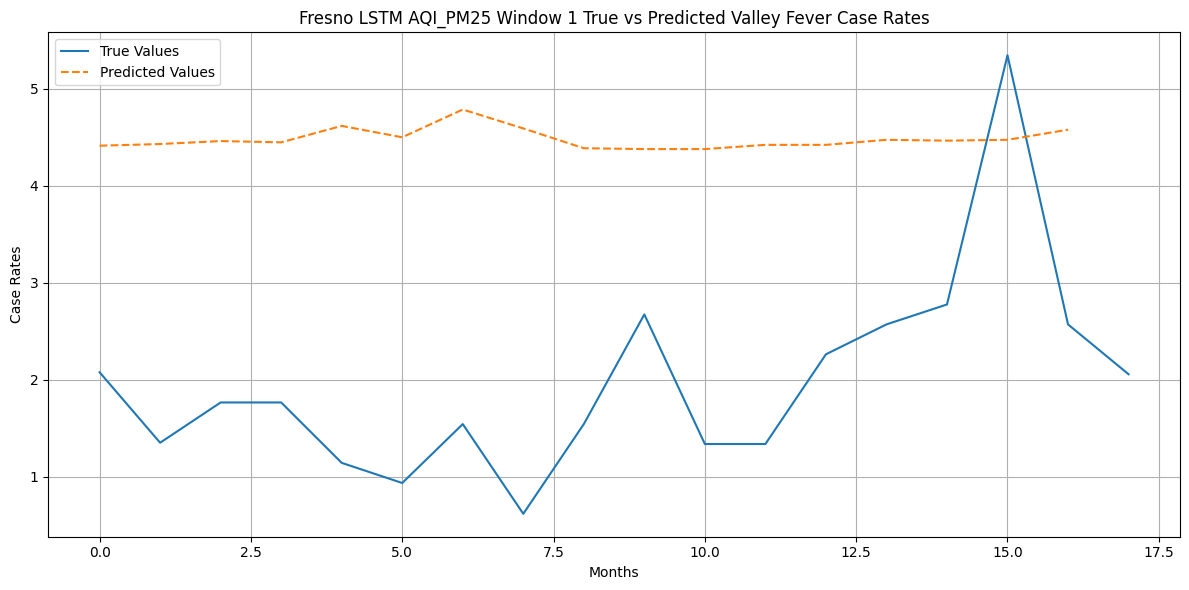

Epoch 1/300 - Training Loss 0.4475, Testing Loss 0.2040
Epoch 11/300 - Training Loss 0.3611, Testing Loss 0.1168
Epoch 21/300 - Training Loss 0.2819, Testing Loss 0.0856
Epoch 31/300 - Training Loss 0.2219, Testing Loss 0.1943
Epoch 41/300 - Training Loss 0.2259, Testing Loss 0.2561
Epoch 51/300 - Training Loss 0.2209, Testing Loss 0.2013
Epoch 61/300 - Training Loss 0.2203, Testing Loss 0.1917
Epoch 71/300 - Training Loss 0.2159, Testing Loss 0.2107
Epoch 81/300 - Training Loss 0.2197, Testing Loss 0.2136
Epoch 91/300 - Training Loss 0.2156, Testing Loss 0.2043
Epoch 101/300 - Training Loss 0.2161, Testing Loss 0.2084
Epoch 111/300 - Training Loss 0.2165, Testing Loss 0.2111
Epoch 121/300 - Training Loss 0.2178, Testing Loss 0.2091
Epoch 131/300 - Training Loss 0.2185, Testing Loss 0.2080
Epoch 141/300 - Training Loss 0.2195, Testing Loss 0.2099
Epoch 151/300 - Training Loss 0.2185, Testing Loss 0.2088
Epoch 161/300 - Training Loss 0.2183, Testing Loss 0.2096
Epoch 171/300 - Training 

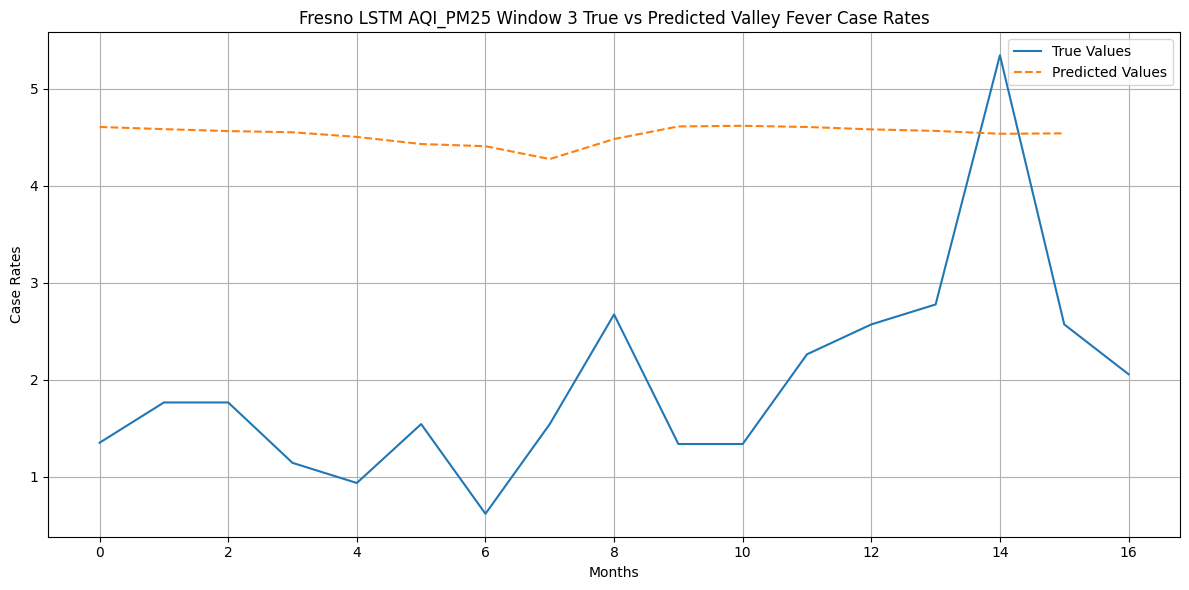

Epoch 1/300 - Training Loss 0.4309, Testing Loss 0.1841
Epoch 11/300 - Training Loss 0.3177, Testing Loss 0.0838
Epoch 21/300 - Training Loss 0.2244, Testing Loss 0.1925
Epoch 31/300 - Training Loss 0.2313, Testing Loss 0.2484
Epoch 41/300 - Training Loss 0.2238, Testing Loss 0.1798
Epoch 51/300 - Training Loss 0.2234, Testing Loss 0.1931
Epoch 61/300 - Training Loss 0.2234, Testing Loss 0.2150
Epoch 71/300 - Training Loss 0.2202, Testing Loss 0.2032
Epoch 81/300 - Training Loss 0.2227, Testing Loss 0.2018
Epoch 91/300 - Training Loss 0.2216, Testing Loss 0.2075
Epoch 101/300 - Training Loss 0.2215, Testing Loss 0.2073
Epoch 111/300 - Training Loss 0.2209, Testing Loss 0.2063
Epoch 121/300 - Training Loss 0.2222, Testing Loss 0.2088
Epoch 131/300 - Training Loss 0.2210, Testing Loss 0.2101
Epoch 141/300 - Training Loss 0.2182, Testing Loss 0.2127
Epoch 151/300 - Training Loss 0.2189, Testing Loss 0.2133
Epoch 161/300 - Training Loss 0.2162, Testing Loss 0.2181
Epoch 171/300 - Training 

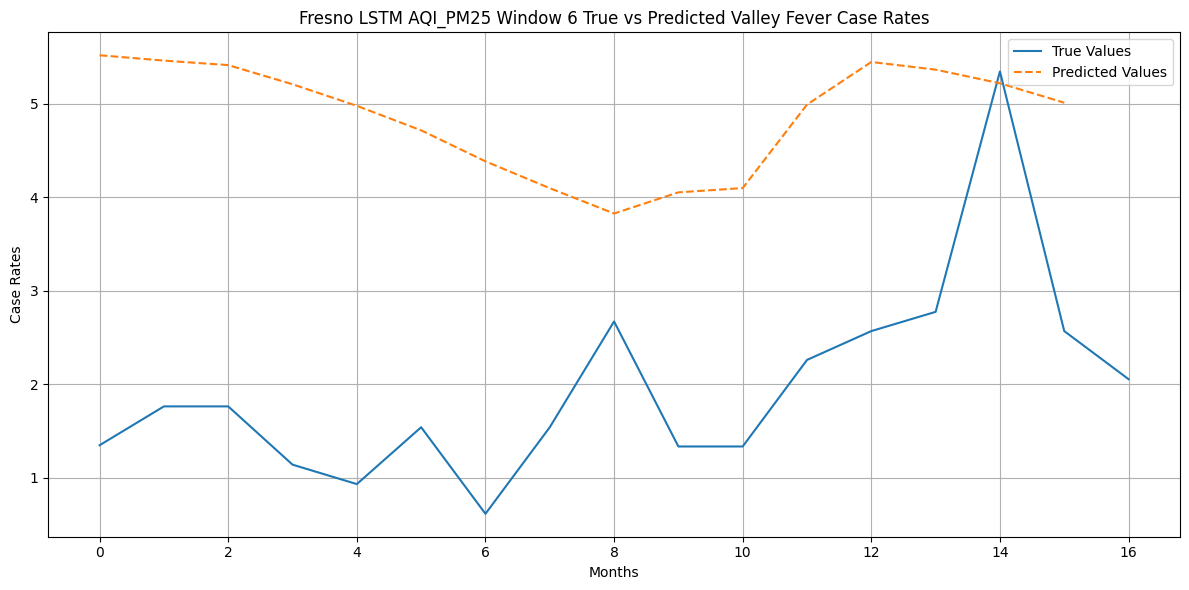

Epoch 1/300 - Training Loss 0.3518, Testing Loss 0.1107
Epoch 11/300 - Training Loss 0.2537, Testing Loss 0.1175
Epoch 21/300 - Training Loss 0.2316, Testing Loss 0.2596
Epoch 31/300 - Training Loss 0.2261, Testing Loss 0.1917
Epoch 41/300 - Training Loss 0.2257, Testing Loss 0.1799
Epoch 51/300 - Training Loss 0.2248, Testing Loss 0.2097
Epoch 61/300 - Training Loss 0.2254, Testing Loss 0.2016
Epoch 71/300 - Training Loss 0.2253, Testing Loss 0.1955
Epoch 81/300 - Training Loss 0.2234, Testing Loss 0.2031
Epoch 91/300 - Training Loss 0.2243, Testing Loss 0.2018
Epoch 101/300 - Training Loss 0.2244, Testing Loss 0.2020
Epoch 111/300 - Training Loss 0.2220, Testing Loss 0.2059
Epoch 121/300 - Training Loss 0.2213, Testing Loss 0.2062
Epoch 131/300 - Training Loss 0.2179, Testing Loss 0.2121
Epoch 141/300 - Training Loss 0.2151, Testing Loss 0.2237
Epoch 151/300 - Training Loss 0.2144, Testing Loss 0.2380
Epoch 161/300 - Training Loss 0.2144, Testing Loss 0.2463
Epoch 171/300 - Training 

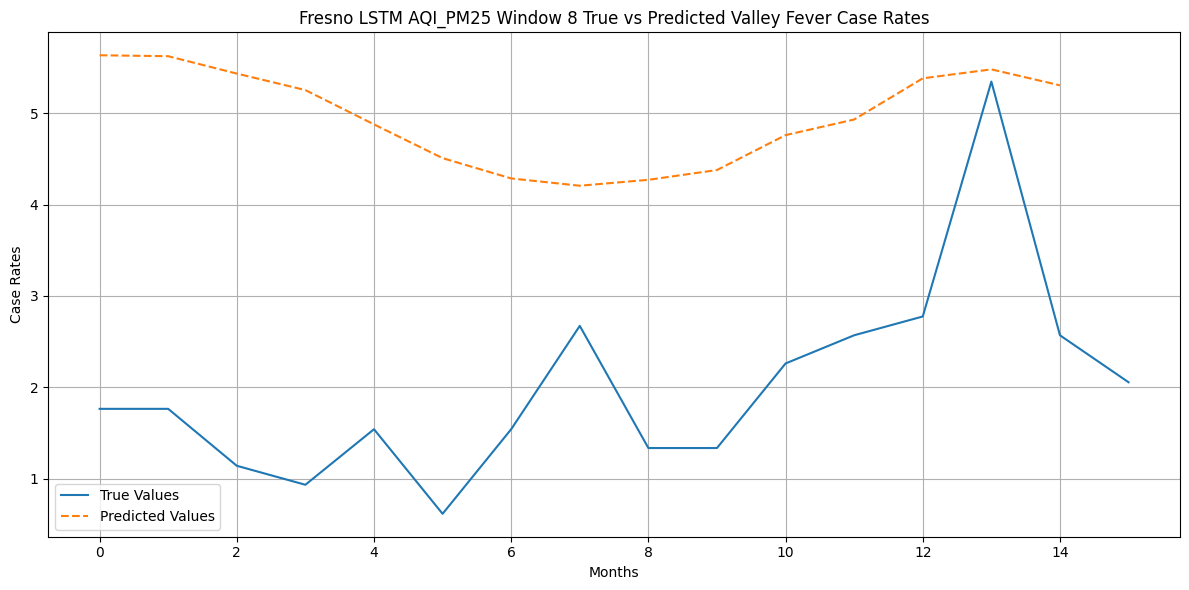

Epoch 1/300 - Training Loss 0.2536, Testing Loss 0.1245
Epoch 11/300 - Training Loss 0.2360, Testing Loss 0.2313
Epoch 21/300 - Training Loss 0.2314, Testing Loss 0.1833
Epoch 31/300 - Training Loss 0.2310, Testing Loss 0.1968
Epoch 41/300 - Training Loss 0.2312, Testing Loss 0.2025
Epoch 51/300 - Training Loss 0.2306, Testing Loss 0.1948
Epoch 61/300 - Training Loss 0.2292, Testing Loss 0.2027
Epoch 71/300 - Training Loss 0.2270, Testing Loss 0.2029
Epoch 81/300 - Training Loss 0.2226, Testing Loss 0.2151
Epoch 91/300 - Training Loss 0.2185, Testing Loss 0.2287
Epoch 101/300 - Training Loss 0.2134, Testing Loss 0.2309
Epoch 111/300 - Training Loss 0.2128, Testing Loss 0.2326
Epoch 121/300 - Training Loss 0.2105, Testing Loss 0.2269
Epoch 131/300 - Training Loss 0.2102, Testing Loss 0.2386
Epoch 141/300 - Training Loss 0.2091, Testing Loss 0.2355
Epoch 151/300 - Training Loss 0.2066, Testing Loss 0.2325
Epoch 161/300 - Training Loss 0.2063, Testing Loss 0.2315
Epoch 171/300 - Training 

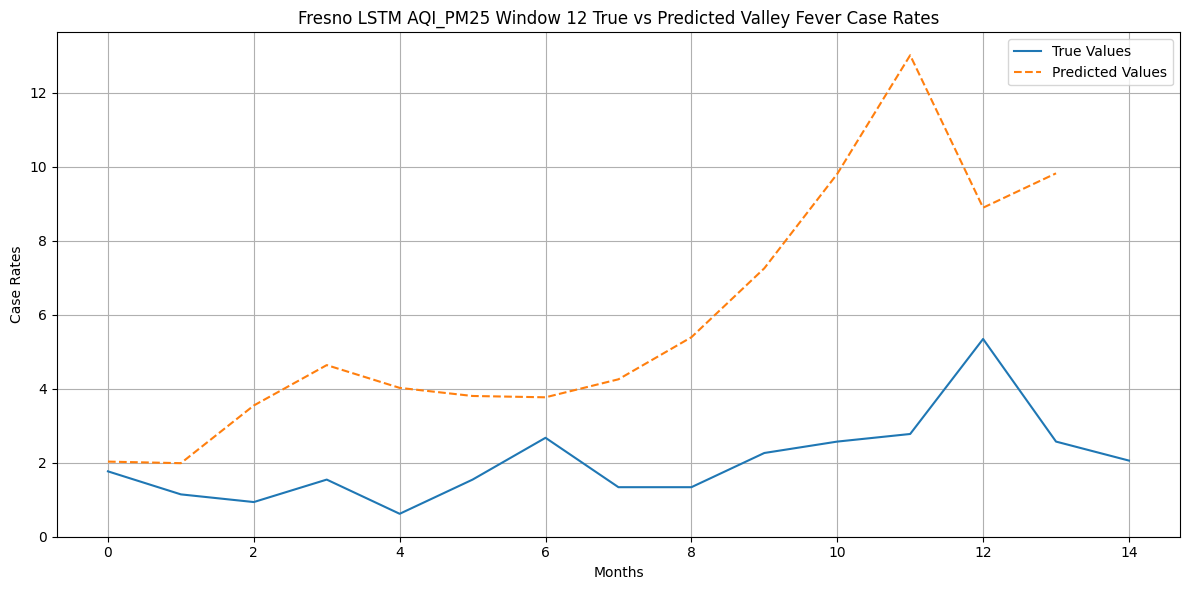

Epoch 1/300 - Training Loss 0.3565, Testing Loss 0.1137
Epoch 11/300 - Training Loss 0.3212, Testing Loss 0.0862
Epoch 21/300 - Training Loss 0.2873, Testing Loss 0.0788
Epoch 31/300 - Training Loss 0.2535, Testing Loss 0.1046
Epoch 41/300 - Training Loss 0.2262, Testing Loss 0.1583
Epoch 51/300 - Training Loss 0.2165, Testing Loss 0.2168
Epoch 61/300 - Training Loss 0.2172, Testing Loss 0.2357
Epoch 71/300 - Training Loss 0.2175, Testing Loss 0.2191
Epoch 81/300 - Training Loss 0.2160, Testing Loss 0.2061
Epoch 91/300 - Training Loss 0.2162, Testing Loss 0.2062
Epoch 101/300 - Training Loss 0.2148, Testing Loss 0.2109
Epoch 111/300 - Training Loss 0.2140, Testing Loss 0.2130
Epoch 121/300 - Training Loss 0.2163, Testing Loss 0.2124
Epoch 131/300 - Training Loss 0.2157, Testing Loss 0.2106
Epoch 141/300 - Training Loss 0.2150, Testing Loss 0.2101
Epoch 151/300 - Training Loss 0.2136, Testing Loss 0.2113
Epoch 161/300 - Training Loss 0.2163, Testing Loss 0.2114
Epoch 171/300 - Training 

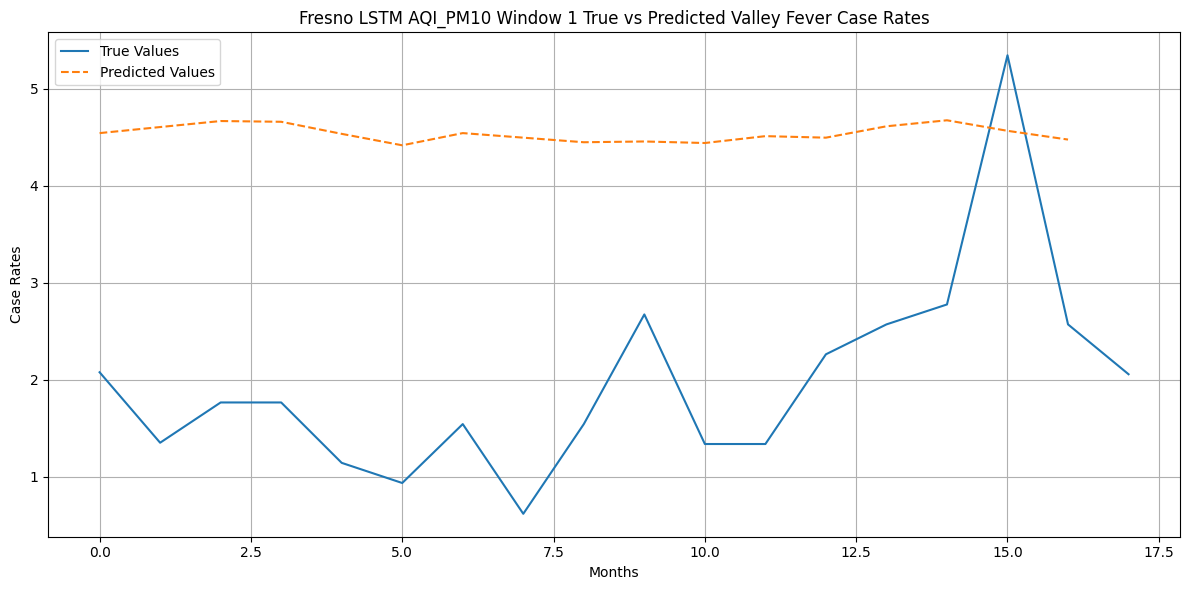

Epoch 1/300 - Training Loss 0.4724, Testing Loss 0.2329
Epoch 11/300 - Training Loss 0.3990, Testing Loss 0.1546
Epoch 21/300 - Training Loss 0.3147, Testing Loss 0.0827
Epoch 31/300 - Training Loss 0.2294, Testing Loss 0.1743
Epoch 41/300 - Training Loss 0.2321, Testing Loss 0.2720
Epoch 51/300 - Training Loss 0.2201, Testing Loss 0.1957
Epoch 61/300 - Training Loss 0.2231, Testing Loss 0.1926
Epoch 71/300 - Training Loss 0.2192, Testing Loss 0.2183
Epoch 81/300 - Training Loss 0.2195, Testing Loss 0.2116
Epoch 91/300 - Training Loss 0.2188, Testing Loss 0.2053
Epoch 101/300 - Training Loss 0.2194, Testing Loss 0.2109
Epoch 111/300 - Training Loss 0.2162, Testing Loss 0.2090
Epoch 121/300 - Training Loss 0.2177, Testing Loss 0.2088
Epoch 131/300 - Training Loss 0.2205, Testing Loss 0.2101
Epoch 141/300 - Training Loss 0.2181, Testing Loss 0.2090
Epoch 151/300 - Training Loss 0.2177, Testing Loss 0.2083
Epoch 161/300 - Training Loss 0.2192, Testing Loss 0.2085
Epoch 171/300 - Training 

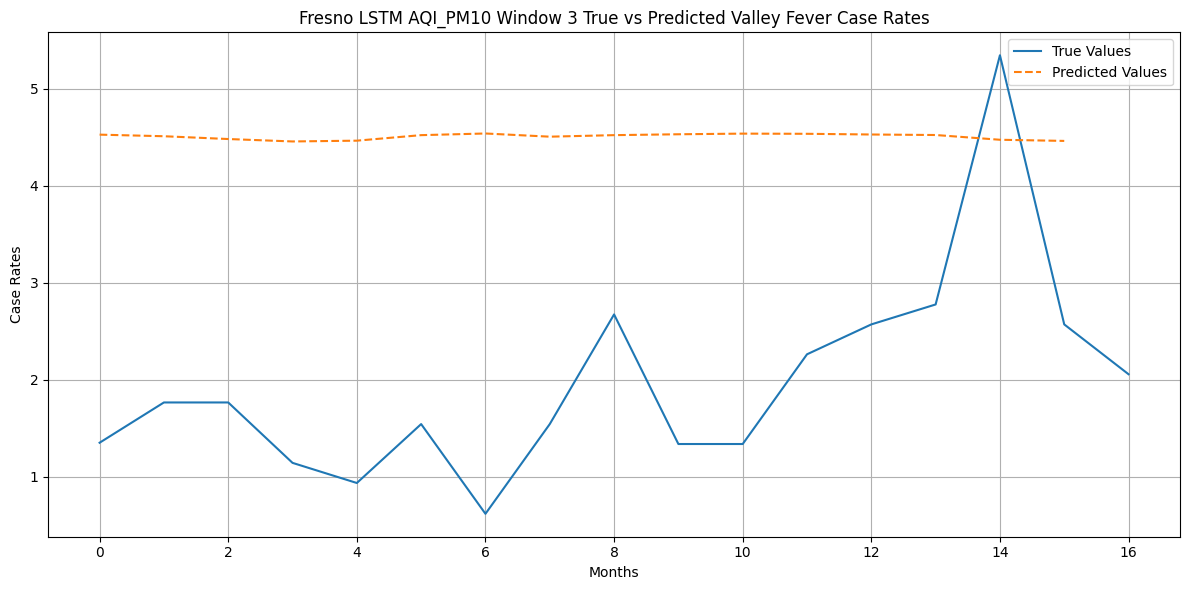

Epoch 1/300 - Training Loss 0.4024, Testing Loss 0.1549
Epoch 11/300 - Training Loss 0.2852, Testing Loss 0.0860
Epoch 21/300 - Training Loss 0.2226, Testing Loss 0.2637
Epoch 31/300 - Training Loss 0.2245, Testing Loss 0.2126
Epoch 41/300 - Training Loss 0.2271, Testing Loss 0.1777
Epoch 51/300 - Training Loss 0.2218, Testing Loss 0.2147
Epoch 61/300 - Training Loss 0.2218, Testing Loss 0.2102
Epoch 71/300 - Training Loss 0.2234, Testing Loss 0.1996
Epoch 81/300 - Training Loss 0.2232, Testing Loss 0.2091
Epoch 91/300 - Training Loss 0.2228, Testing Loss 0.2051
Epoch 101/300 - Training Loss 0.2221, Testing Loss 0.2041
Epoch 111/300 - Training Loss 0.2190, Testing Loss 0.2064
Epoch 121/300 - Training Loss 0.2208, Testing Loss 0.2039
Epoch 131/300 - Training Loss 0.2212, Testing Loss 0.2050
Epoch 141/300 - Training Loss 0.2190, Testing Loss 0.2049
Epoch 151/300 - Training Loss 0.2186, Testing Loss 0.2064
Epoch 161/300 - Training Loss 0.2147, Testing Loss 0.2015
Epoch 171/300 - Training 

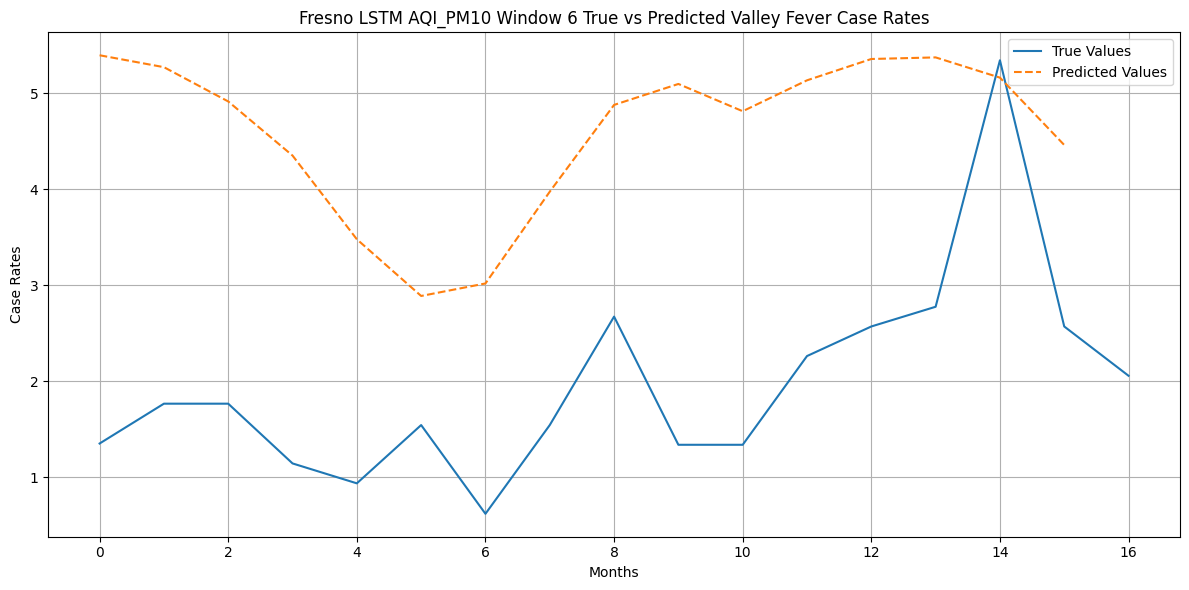

Epoch 1/300 - Training Loss 0.4257, Testing Loss 0.1876
Epoch 11/300 - Training Loss 0.3377, Testing Loss 0.1009
Epoch 21/300 - Training Loss 0.2490, Testing Loss 0.1284
Epoch 31/300 - Training Loss 0.2372, Testing Loss 0.2620
Epoch 41/300 - Training Loss 0.2248, Testing Loss 0.1749
Epoch 51/300 - Training Loss 0.2249, Testing Loss 0.1864
Epoch 61/300 - Training Loss 0.2242, Testing Loss 0.2126
Epoch 71/300 - Training Loss 0.2244, Testing Loss 0.1930
Epoch 81/300 - Training Loss 0.2247, Testing Loss 0.1980
Epoch 91/300 - Training Loss 0.2249, Testing Loss 0.2001
Epoch 101/300 - Training Loss 0.2225, Testing Loss 0.1964
Epoch 111/300 - Training Loss 0.2188, Testing Loss 0.1982
Epoch 121/300 - Training Loss 0.2172, Testing Loss 0.1978
Epoch 131/300 - Training Loss 0.2037, Testing Loss 0.1893
Epoch 141/300 - Training Loss 0.2003, Testing Loss 0.1898
Epoch 151/300 - Training Loss 0.1977, Testing Loss 0.1943
Epoch 161/300 - Training Loss 0.1992, Testing Loss 0.1958
Epoch 171/300 - Training 

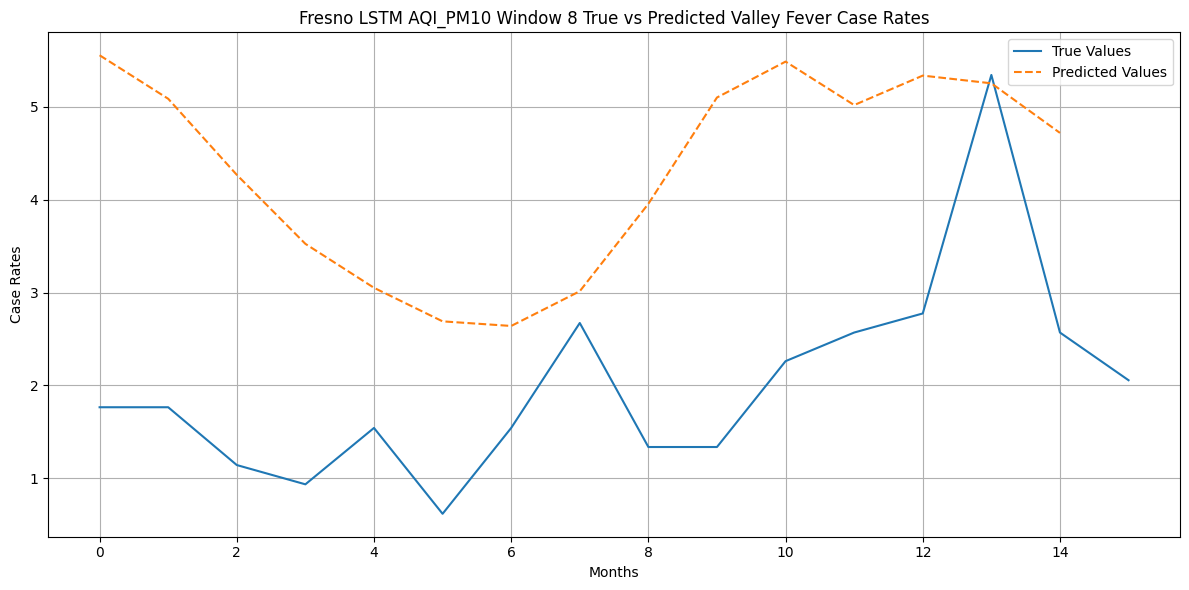

Epoch 1/300 - Training Loss 0.4321, Testing Loss 0.1892
Epoch 11/300 - Training Loss 0.2949, Testing Loss 0.0861
Epoch 21/300 - Training Loss 0.2391, Testing Loss 0.2612
Epoch 31/300 - Training Loss 0.2313, Testing Loss 0.1972
Epoch 41/300 - Training Loss 0.2336, Testing Loss 0.1719
Epoch 51/300 - Training Loss 0.2299, Testing Loss 0.2049
Epoch 61/300 - Training Loss 0.2290, Testing Loss 0.1991
Epoch 71/300 - Training Loss 0.2264, Testing Loss 0.1908
Epoch 81/300 - Training Loss 0.2276, Testing Loss 0.1975
Epoch 91/300 - Training Loss 0.2259, Testing Loss 0.1919
Epoch 101/300 - Training Loss 0.2201, Testing Loss 0.1910
Epoch 111/300 - Training Loss 0.2023, Testing Loss 0.1726
Epoch 121/300 - Training Loss 0.1884, Testing Loss 0.1106
Epoch 131/300 - Training Loss 0.1802, Testing Loss 0.1363
Epoch 141/300 - Training Loss 0.1800, Testing Loss 0.1117
Epoch 151/300 - Training Loss 0.1784, Testing Loss 0.1075
Epoch 161/300 - Training Loss 0.1826, Testing Loss 0.1256
Epoch 171/300 - Training 

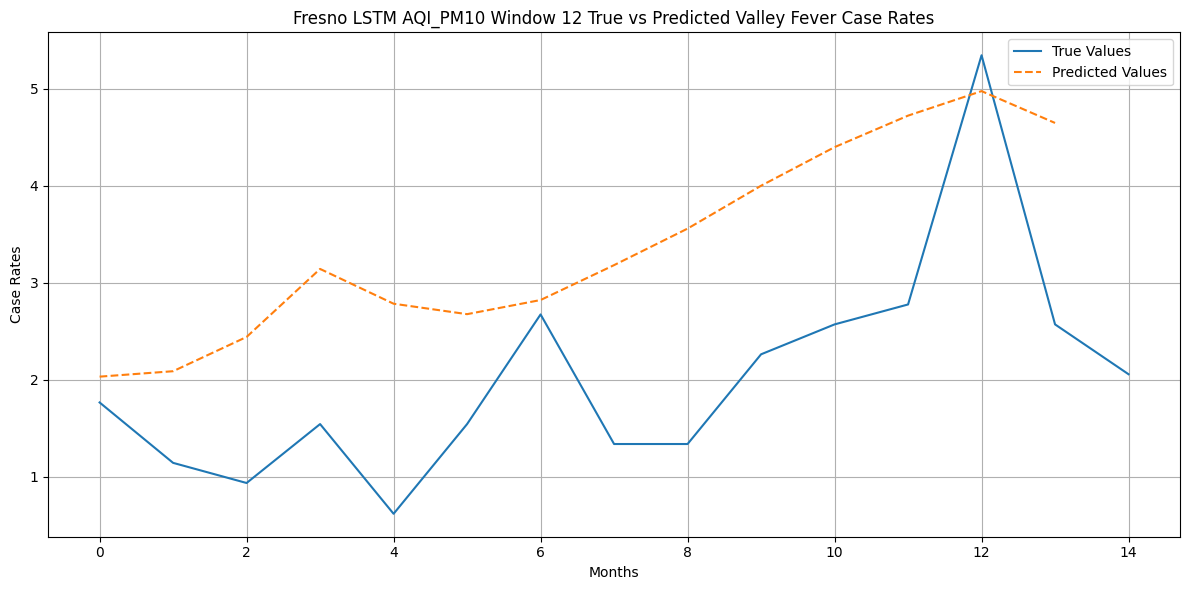

Epoch 1/300 - Training Loss 0.2400, Testing Loss 0.1239
Epoch 11/300 - Training Loss 0.2256, Testing Loss 0.1576
Epoch 21/300 - Training Loss 0.2180, Testing Loss 0.1927
Epoch 31/300 - Training Loss 0.2168, Testing Loss 0.2183
Epoch 41/300 - Training Loss 0.2166, Testing Loss 0.2216
Epoch 51/300 - Training Loss 0.2162, Testing Loss 0.2136
Epoch 61/300 - Training Loss 0.2169, Testing Loss 0.2085
Epoch 71/300 - Training Loss 0.2164, Testing Loss 0.2091
Epoch 81/300 - Training Loss 0.2169, Testing Loss 0.2118
Epoch 91/300 - Training Loss 0.2165, Testing Loss 0.2122
Epoch 101/300 - Training Loss 0.2162, Testing Loss 0.2118
Epoch 111/300 - Training Loss 0.2158, Testing Loss 0.2115
Epoch 121/300 - Training Loss 0.2165, Testing Loss 0.2116
Epoch 131/300 - Training Loss 0.2162, Testing Loss 0.2116
Epoch 141/300 - Training Loss 0.2171, Testing Loss 0.2117
Epoch 151/300 - Training Loss 0.2168, Testing Loss 0.2118
Epoch 161/300 - Training Loss 0.2164, Testing Loss 0.2113
Epoch 171/300 - Training 

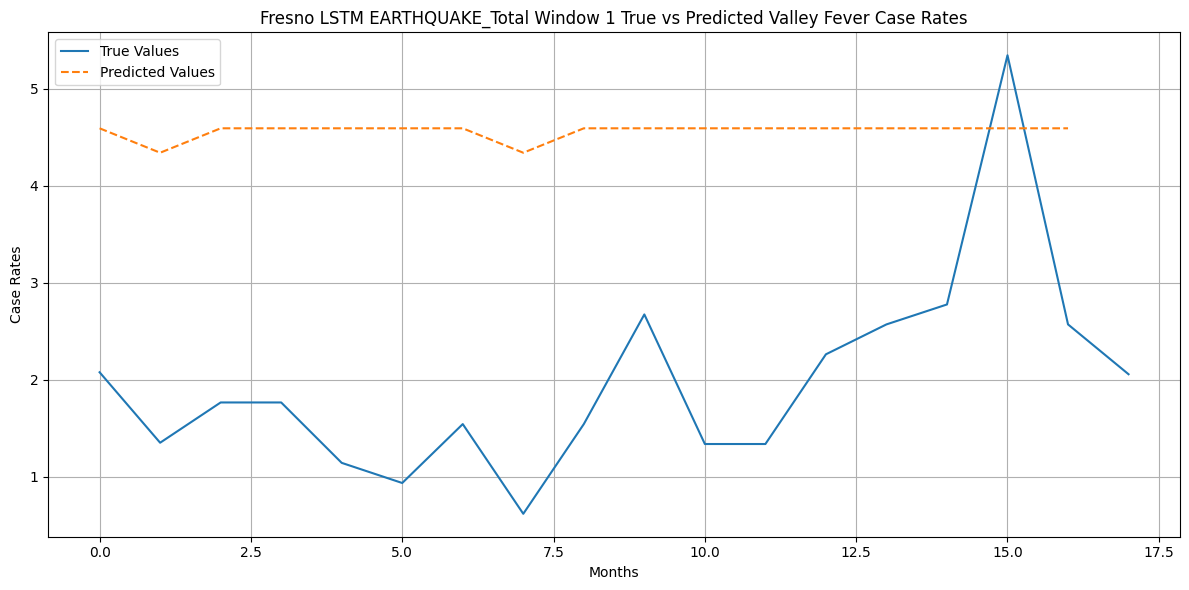

Epoch 1/300 - Training Loss 0.2527, Testing Loss 0.1099
Epoch 11/300 - Training Loss 0.2201, Testing Loss 0.1903
Epoch 21/300 - Training Loss 0.2203, Testing Loss 0.2374
Epoch 31/300 - Training Loss 0.2176, Testing Loss 0.2087
Epoch 41/300 - Training Loss 0.2179, Testing Loss 0.1994
Epoch 51/300 - Training Loss 0.2185, Testing Loss 0.2100
Epoch 61/300 - Training Loss 0.2184, Testing Loss 0.2124
Epoch 71/300 - Training Loss 0.2183, Testing Loss 0.2075
Epoch 81/300 - Training Loss 0.2184, Testing Loss 0.2079
Epoch 91/300 - Training Loss 0.2182, Testing Loss 0.2106
Epoch 101/300 - Training Loss 0.2185, Testing Loss 0.2088
Epoch 111/300 - Training Loss 0.2182, Testing Loss 0.2084
Epoch 121/300 - Training Loss 0.2179, Testing Loss 0.2096
Epoch 131/300 - Training Loss 0.2184, Testing Loss 0.2098
Epoch 141/300 - Training Loss 0.2184, Testing Loss 0.2094
Epoch 151/300 - Training Loss 0.2189, Testing Loss 0.2090
Epoch 161/300 - Training Loss 0.2183, Testing Loss 0.2095
Epoch 171/300 - Training 

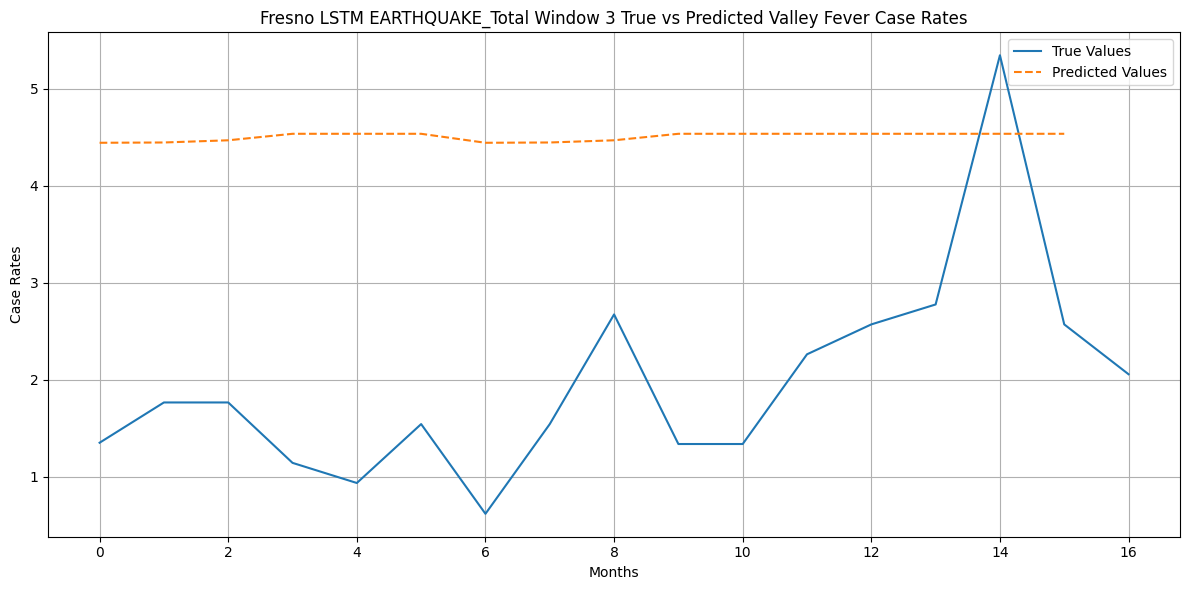

Epoch 1/300 - Training Loss 0.3921, Testing Loss 0.1463
Epoch 11/300 - Training Loss 0.3078, Testing Loss 0.0812
Epoch 21/300 - Training Loss 0.2372, Testing Loss 0.1456
Epoch 31/300 - Training Loss 0.2275, Testing Loss 0.2593
Epoch 41/300 - Training Loss 0.2224, Testing Loss 0.1988
Epoch 51/300 - Training Loss 0.2216, Testing Loss 0.1890
Epoch 61/300 - Training Loss 0.2228, Testing Loss 0.2120
Epoch 71/300 - Training Loss 0.2224, Testing Loss 0.2087
Epoch 81/300 - Training Loss 0.2221, Testing Loss 0.2030
Epoch 91/300 - Training Loss 0.2219, Testing Loss 0.2078
Epoch 101/300 - Training Loss 0.2206, Testing Loss 0.2071
Epoch 111/300 - Training Loss 0.2231, Testing Loss 0.2055
Epoch 121/300 - Training Loss 0.2220, Testing Loss 0.2073
Epoch 131/300 - Training Loss 0.2200, Testing Loss 0.2100
Epoch 141/300 - Training Loss 0.2216, Testing Loss 0.2069
Epoch 151/300 - Training Loss 0.2204, Testing Loss 0.2084
Epoch 161/300 - Training Loss 0.2208, Testing Loss 0.2090
Epoch 171/300 - Training 

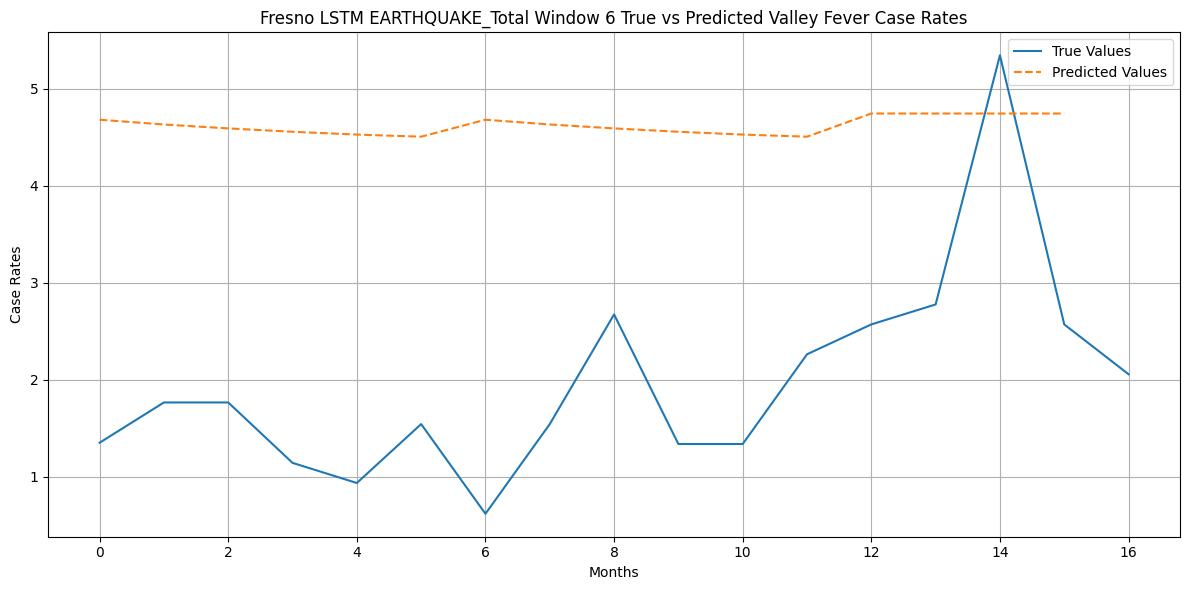

Epoch 1/300 - Training Loss 0.3720, Testing Loss 0.1282
Epoch 11/300 - Training Loss 0.2563, Testing Loss 0.1147
Epoch 21/300 - Training Loss 0.2347, Testing Loss 0.2641
Epoch 31/300 - Training Loss 0.2247, Testing Loss 0.1927
Epoch 41/300 - Training Loss 0.2275, Testing Loss 0.1802
Epoch 51/300 - Training Loss 0.2255, Testing Loss 0.2080
Epoch 61/300 - Training Loss 0.2259, Testing Loss 0.2022
Epoch 71/300 - Training Loss 0.2271, Testing Loss 0.1952
Epoch 81/300 - Training Loss 0.2259, Testing Loss 0.2025
Epoch 91/300 - Training Loss 0.2252, Testing Loss 0.1999
Epoch 101/300 - Training Loss 0.2254, Testing Loss 0.1997
Epoch 111/300 - Training Loss 0.2234, Testing Loss 0.2011
Epoch 121/300 - Training Loss 0.2262, Testing Loss 0.2005
Epoch 131/300 - Training Loss 0.2251, Testing Loss 0.2001
Epoch 141/300 - Training Loss 0.2234, Testing Loss 0.2011
Epoch 151/300 - Training Loss 0.2259, Testing Loss 0.2019
Epoch 161/300 - Training Loss 0.2235, Testing Loss 0.2005
Epoch 171/300 - Training 

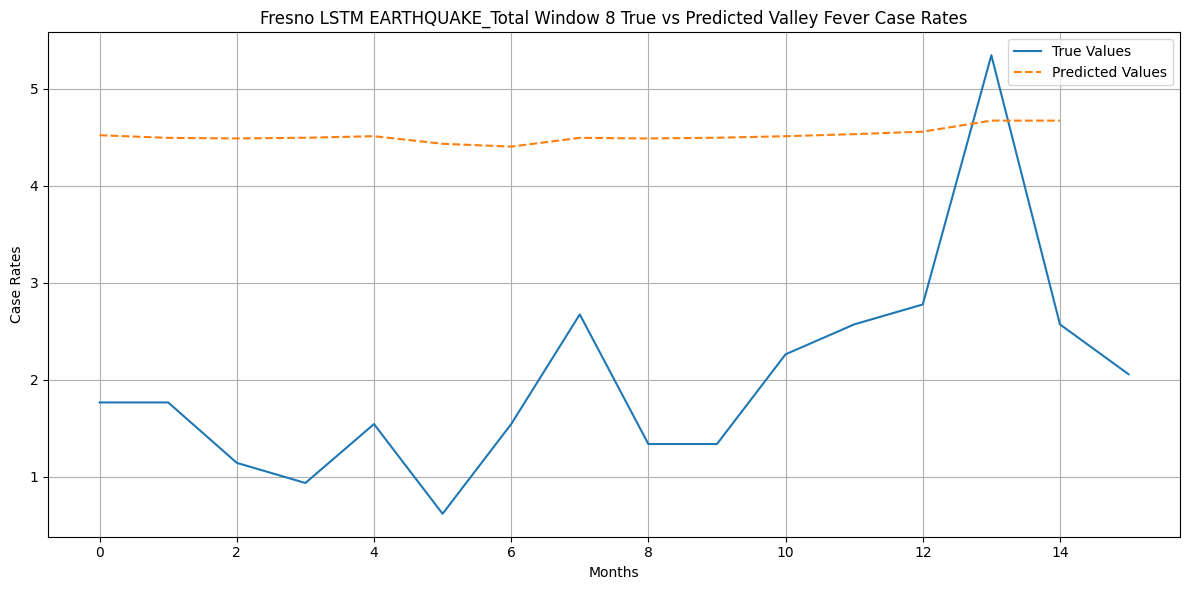

Epoch 1/300 - Training Loss 0.4120, Testing Loss 0.1725
Epoch 11/300 - Training Loss 0.3153, Testing Loss 0.0874
Epoch 21/300 - Training Loss 0.2364, Testing Loss 0.1763
Epoch 31/300 - Training Loss 0.2363, Testing Loss 0.2345
Epoch 41/300 - Training Loss 0.2347, Testing Loss 0.1723
Epoch 51/300 - Training Loss 0.2311, Testing Loss 0.1898
Epoch 61/300 - Training Loss 0.2333, Testing Loss 0.2069
Epoch 71/300 - Training Loss 0.2298, Testing Loss 0.1951
Epoch 81/300 - Training Loss 0.2335, Testing Loss 0.1945
Epoch 91/300 - Training Loss 0.2334, Testing Loss 0.1980
Epoch 101/300 - Training Loss 0.2329, Testing Loss 0.1965
Epoch 111/300 - Training Loss 0.2348, Testing Loss 0.1969
Epoch 121/300 - Training Loss 0.2323, Testing Loss 0.1964
Epoch 131/300 - Training Loss 0.2323, Testing Loss 0.1958
Epoch 141/300 - Training Loss 0.2293, Testing Loss 0.1969
Epoch 151/300 - Training Loss 0.2312, Testing Loss 0.1974
Epoch 161/300 - Training Loss 0.2329, Testing Loss 0.1975
Epoch 171/300 - Training 

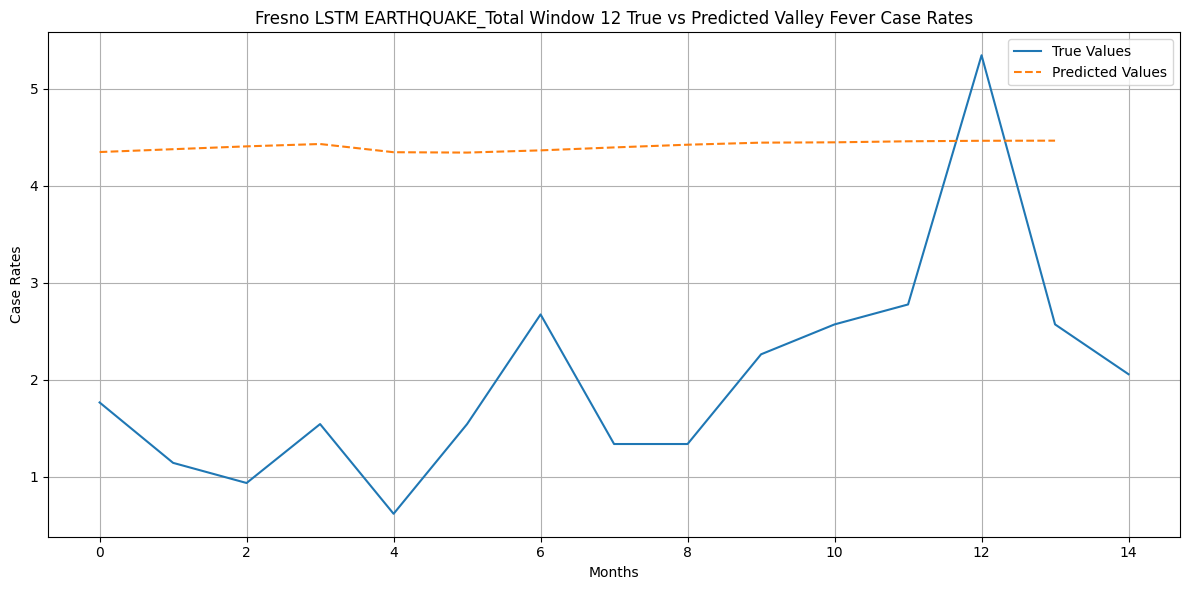

Epoch 1/300 - Training Loss 0.4894, Testing Loss 0.2508
Epoch 11/300 - Training Loss 0.4495, Testing Loss 0.2082
Epoch 21/300 - Training Loss 0.4072, Testing Loss 0.1633
Epoch 31/300 - Training Loss 0.3602, Testing Loss 0.1155
Epoch 41/300 - Training Loss 0.3067, Testing Loss 0.0791
Epoch 51/300 - Training Loss 0.2491, Testing Loss 0.1118
Epoch 61/300 - Training Loss 0.2236, Testing Loss 0.1964
Epoch 71/300 - Training Loss 0.2230, Testing Loss 0.2424
Epoch 81/300 - Training Loss 0.2177, Testing Loss 0.2232
Epoch 91/300 - Training Loss 0.2191, Testing Loss 0.2016
Epoch 101/300 - Training Loss 0.2213, Testing Loss 0.2007
Epoch 111/300 - Training Loss 0.2205, Testing Loss 0.2083
Epoch 121/300 - Training Loss 0.2180, Testing Loss 0.2129
Epoch 131/300 - Training Loss 0.2143, Testing Loss 0.2116
Epoch 141/300 - Training Loss 0.2219, Testing Loss 0.2086
Epoch 151/300 - Training Loss 0.2152, Testing Loss 0.2083
Epoch 161/300 - Training Loss 0.2148, Testing Loss 0.2113
Epoch 171/300 - Training 

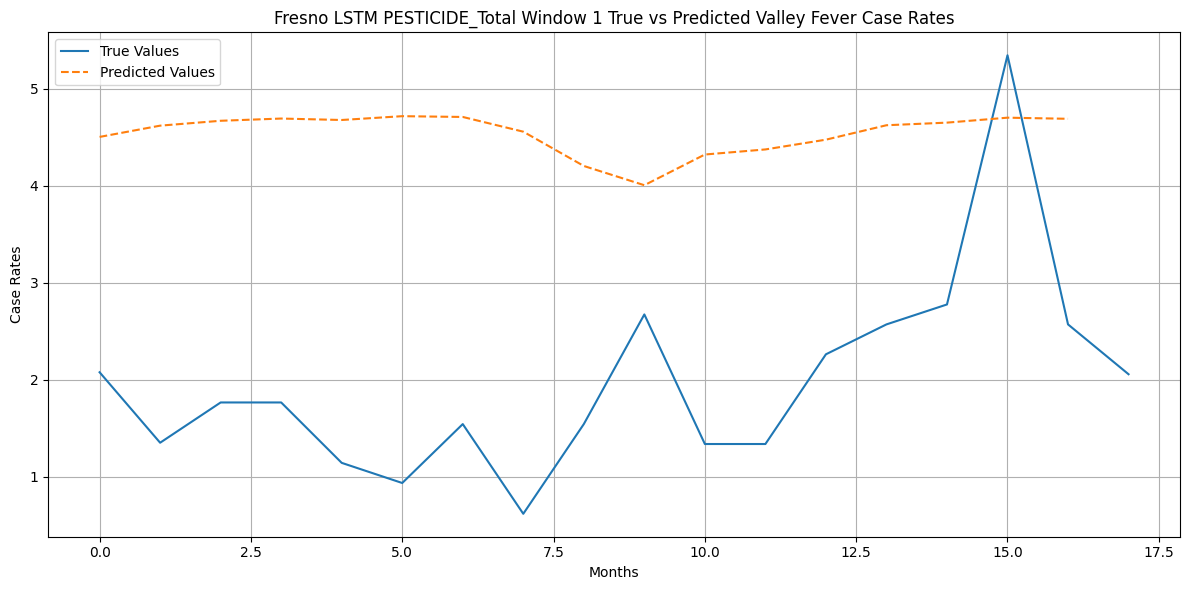

Epoch 1/300 - Training Loss 0.4126, Testing Loss 0.1662
Epoch 11/300 - Training Loss 0.3241, Testing Loss 0.0877
Epoch 21/300 - Training Loss 0.2482, Testing Loss 0.1197
Epoch 31/300 - Training Loss 0.2213, Testing Loss 0.2372
Epoch 41/300 - Training Loss 0.2232, Testing Loss 0.2364
Epoch 51/300 - Training Loss 0.2184, Testing Loss 0.1934
Epoch 61/300 - Training Loss 0.2198, Testing Loss 0.1969
Epoch 71/300 - Training Loss 0.2193, Testing Loss 0.2137
Epoch 81/300 - Training Loss 0.2202, Testing Loss 0.2114
Epoch 91/300 - Training Loss 0.2165, Testing Loss 0.2055
Epoch 101/300 - Training Loss 0.2190, Testing Loss 0.2085
Epoch 111/300 - Training Loss 0.2159, Testing Loss 0.2106
Epoch 121/300 - Training Loss 0.2170, Testing Loss 0.2088
Epoch 131/300 - Training Loss 0.2179, Testing Loss 0.2087
Epoch 141/300 - Training Loss 0.2181, Testing Loss 0.2108
Epoch 151/300 - Training Loss 0.2172, Testing Loss 0.2110
Epoch 161/300 - Training Loss 0.2158, Testing Loss 0.2094
Epoch 171/300 - Training 

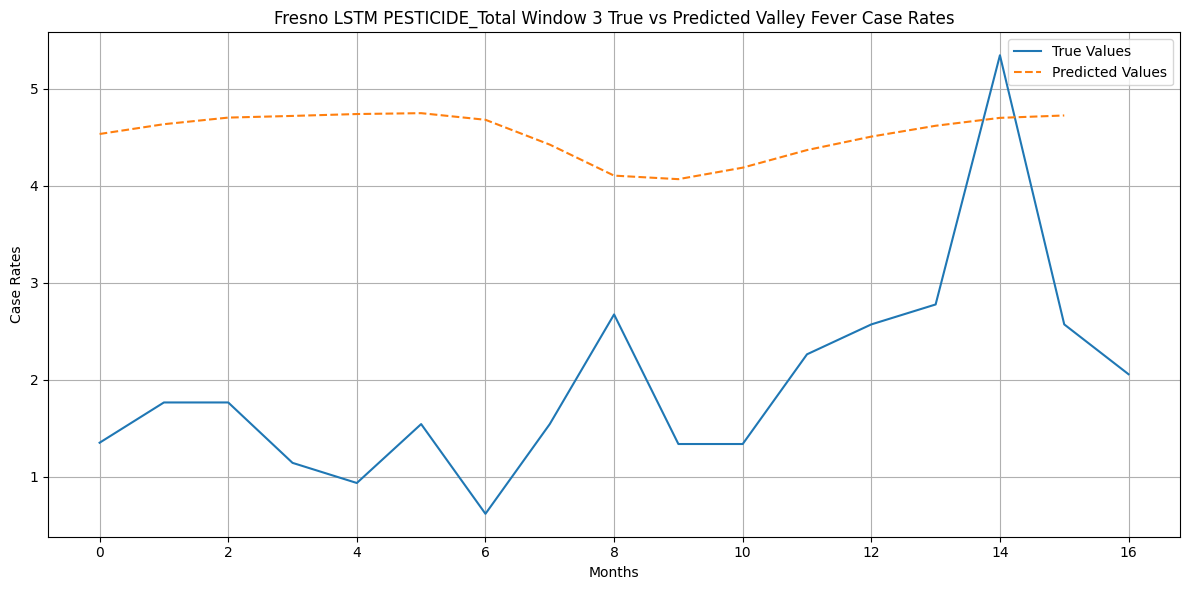

Epoch 1/300 - Training Loss 0.5102, Testing Loss 0.2695
Epoch 11/300 - Training Loss 0.3964, Testing Loss 0.1480
Epoch 21/300 - Training Loss 0.2704, Testing Loss 0.0978
Epoch 31/300 - Training Loss 0.2381, Testing Loss 0.2884
Epoch 41/300 - Training Loss 0.2209, Testing Loss 0.1901
Epoch 51/300 - Training Loss 0.2229, Testing Loss 0.1816
Epoch 61/300 - Training Loss 0.2220, Testing Loss 0.2200
Epoch 71/300 - Training Loss 0.2206, Testing Loss 0.2047
Epoch 81/300 - Training Loss 0.2220, Testing Loss 0.2013
Epoch 91/300 - Training Loss 0.2208, Testing Loss 0.2082
Epoch 101/300 - Training Loss 0.2190, Testing Loss 0.2045
Epoch 111/300 - Training Loss 0.2216, Testing Loss 0.2065
Epoch 121/300 - Training Loss 0.2220, Testing Loss 0.2062
Epoch 131/300 - Training Loss 0.2200, Testing Loss 0.2061
Epoch 141/300 - Training Loss 0.2191, Testing Loss 0.2061
Epoch 151/300 - Training Loss 0.2203, Testing Loss 0.2070
Epoch 161/300 - Training Loss 0.2210, Testing Loss 0.2054
Epoch 171/300 - Training 

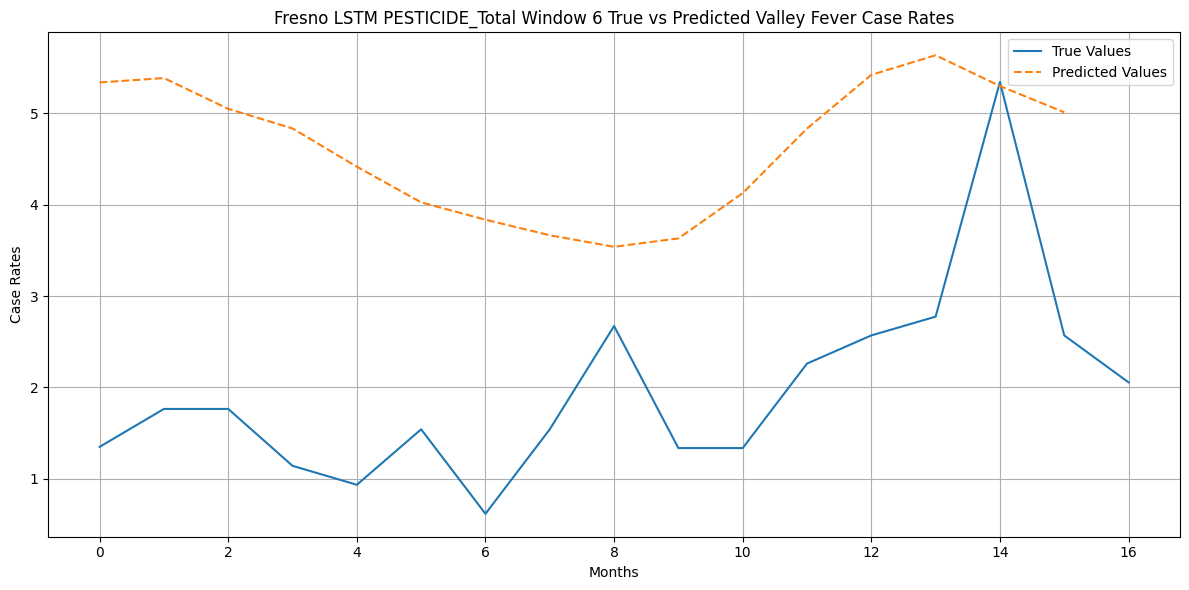

Epoch 1/300 - Training Loss 0.3307, Testing Loss 0.0934
Epoch 11/300 - Training Loss 0.2402, Testing Loss 0.1430
Epoch 21/300 - Training Loss 0.2306, Testing Loss 0.2486
Epoch 31/300 - Training Loss 0.2244, Testing Loss 0.1970
Epoch 41/300 - Training Loss 0.2279, Testing Loss 0.1829
Epoch 51/300 - Training Loss 0.2268, Testing Loss 0.2026
Epoch 61/300 - Training Loss 0.2259, Testing Loss 0.2040
Epoch 71/300 - Training Loss 0.2237, Testing Loss 0.1954
Epoch 81/300 - Training Loss 0.2250, Testing Loss 0.2004
Epoch 91/300 - Training Loss 0.2238, Testing Loss 0.2017
Epoch 101/300 - Training Loss 0.2240, Testing Loss 0.1997
Epoch 111/300 - Training Loss 0.2219, Testing Loss 0.2028
Epoch 121/300 - Training Loss 0.2206, Testing Loss 0.2035
Epoch 131/300 - Training Loss 0.2173, Testing Loss 0.1995
Epoch 141/300 - Training Loss 0.2168, Testing Loss 0.1918
Epoch 151/300 - Training Loss 0.2163, Testing Loss 0.1953
Epoch 161/300 - Training Loss 0.2164, Testing Loss 0.2001
Epoch 171/300 - Training 

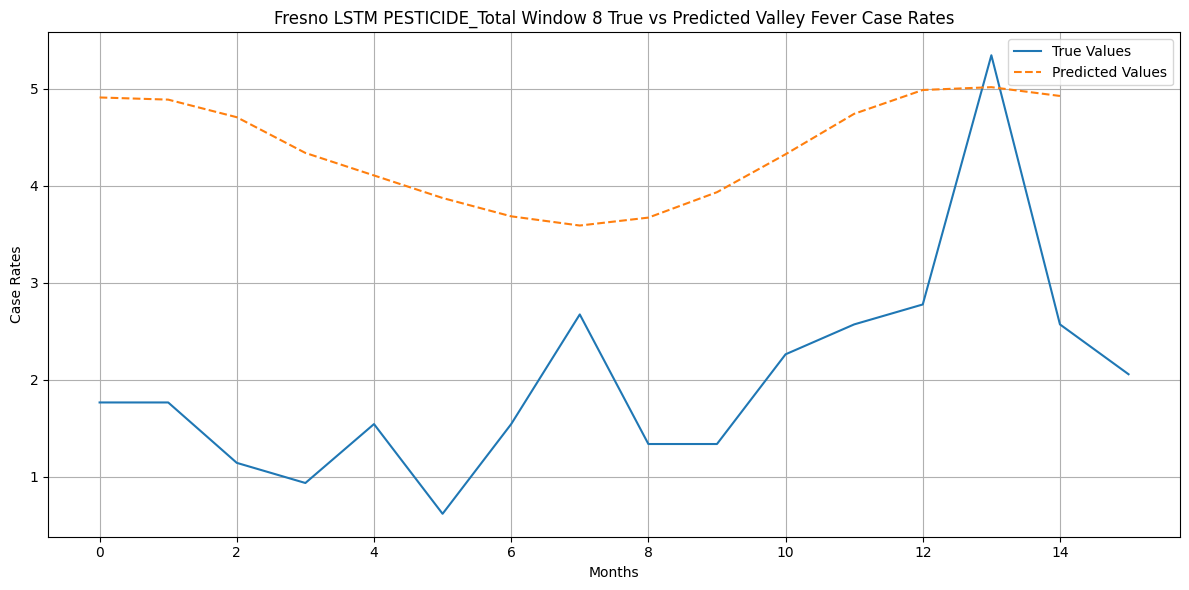

Epoch 1/300 - Training Loss 0.3366, Testing Loss 0.0982
Epoch 11/300 - Training Loss 0.2451, Testing Loss 0.1472
Epoch 21/300 - Training Loss 0.2384, Testing Loss 0.2469
Epoch 31/300 - Training Loss 0.2318, Testing Loss 0.1858
Epoch 41/300 - Training Loss 0.2333, Testing Loss 0.1819
Epoch 51/300 - Training Loss 0.2302, Testing Loss 0.2031
Epoch 61/300 - Training Loss 0.2310, Testing Loss 0.1986
Epoch 71/300 - Training Loss 0.2314, Testing Loss 0.1927
Epoch 81/300 - Training Loss 0.2319, Testing Loss 0.1979
Epoch 91/300 - Training Loss 0.2324, Testing Loss 0.1966
Epoch 101/300 - Training Loss 0.2314, Testing Loss 0.1955
Epoch 111/300 - Training Loss 0.2332, Testing Loss 0.1969
Epoch 121/300 - Training Loss 0.2317, Testing Loss 0.1954
Epoch 131/300 - Training Loss 0.2323, Testing Loss 0.1970
Epoch 141/300 - Training Loss 0.2313, Testing Loss 0.1966
Epoch 151/300 - Training Loss 0.2294, Testing Loss 0.1983
Epoch 161/300 - Training Loss 0.2302, Testing Loss 0.1974
Epoch 171/300 - Training 

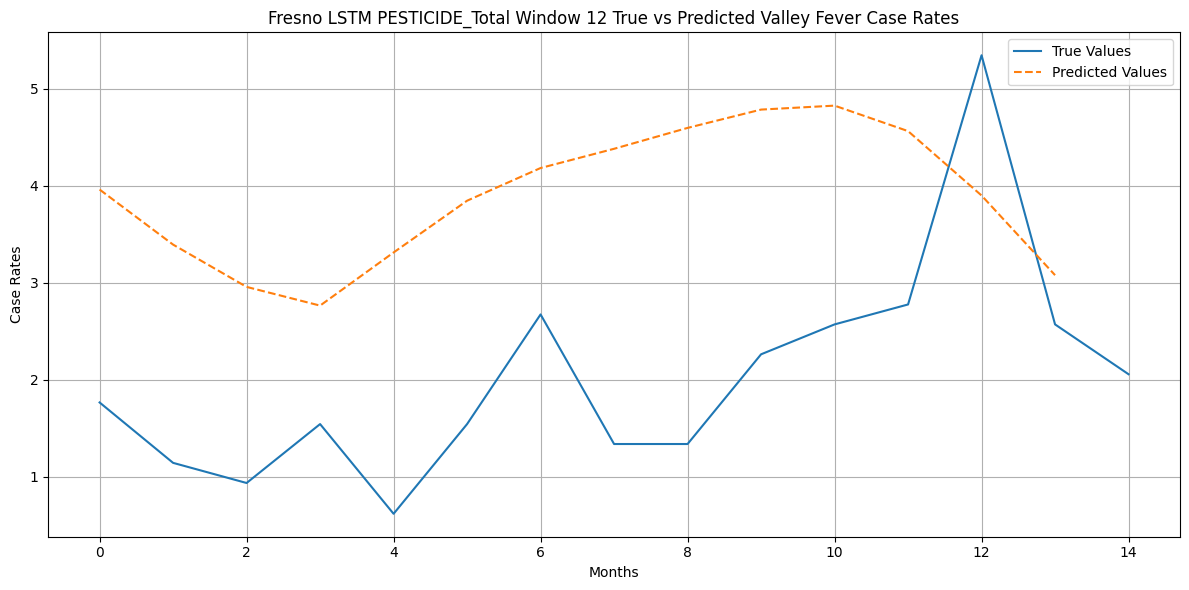

In [8]:
# now loop through each feature and sliding window size
for feature_index, feature in enumerate(feature_columns):
  # generate the feature vector and target vector
  for window_size in sliding_window_sizes:
    X_train, X_test, y_train, y_test = preprocess_data(X, y, feature_index, window_size)
    
    # scale the data
    X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = scale_data(X_train, X_test, y_train, y_test)
    
    # Convert to PyTorch tensors and reshape for LSTM input
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    X_test_tensor  = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32).view(-1, 1)
    y_test_tensor  = torch.tensor(y_test_scaled, dtype=torch.float32).view(-1, 1)

    # Initialize the model
    model = LSTM(input_size=1, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout)
    
    # Define optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    # Create Trainer instance
    trainer = TrainerNewNew(model, criterion, optimizer, scaler_y)
    
    # Train the model
    history, train_preds_inv, y_train_true = trainer.train(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, epochs)
    
    # Evaluate the model
    y_pred_inv, y_true_inv = trainer.evaluate(X_test_tensor, y_test_tensor)
    
    # Calculate RMSE for test set
    rmse = np.sqrt(np.mean((y_pred_inv - y_true_inv) ** 2))
    
    # Store results
    results.append({
        'feature': feature,
        'window_size': window_size,
        'rmse': rmse
    })
    
    print(f"Feature: {feature}, Window Size: {window_size}, Test RMSE: {rmse:.4f}")
    
    # Optionally visualize results for each run
    trainer.visualize_results(y_true_inv, y_pred_inv, county_name="Fresno", model_type="LSTM", title_text=f"{feature} Window {window_size}", show_plot=True, save_fig=False)

(87, 9)
Epoch 1/300 - Training Loss 0.2906, Testing Loss 0.0780
Epoch 11/300 - Training Loss 0.2628, Testing Loss 0.0936
Epoch 21/300 - Training Loss 0.2376, Testing Loss 0.1281
Epoch 31/300 - Training Loss 0.2196, Testing Loss 0.1758
Epoch 41/300 - Training Loss 0.2164, Testing Loss 0.2169
Epoch 51/300 - Training Loss 0.2183, Testing Loss 0.2200
Epoch 61/300 - Training Loss 0.2166, Testing Loss 0.2080
Epoch 71/300 - Training Loss 0.2165, Testing Loss 0.2040
Epoch 81/300 - Training Loss 0.2155, Testing Loss 0.2093
Epoch 91/300 - Training Loss 0.2163, Testing Loss 0.2139
Epoch 101/300 - Training Loss 0.2147, Testing Loss 0.2131
Epoch 111/300 - Training Loss 0.2139, Testing Loss 0.2138
Epoch 121/300 - Training Loss 0.2133, Testing Loss 0.2136
Epoch 131/300 - Training Loss 0.2145, Testing Loss 0.2152
Epoch 141/300 - Training Loss 0.2124, Testing Loss 0.2167
Epoch 151/300 - Training Loss 0.2118, Testing Loss 0.2179
Epoch 161/300 - Training Loss 0.2129, Testing Loss 0.2195
Epoch 171/300 - T

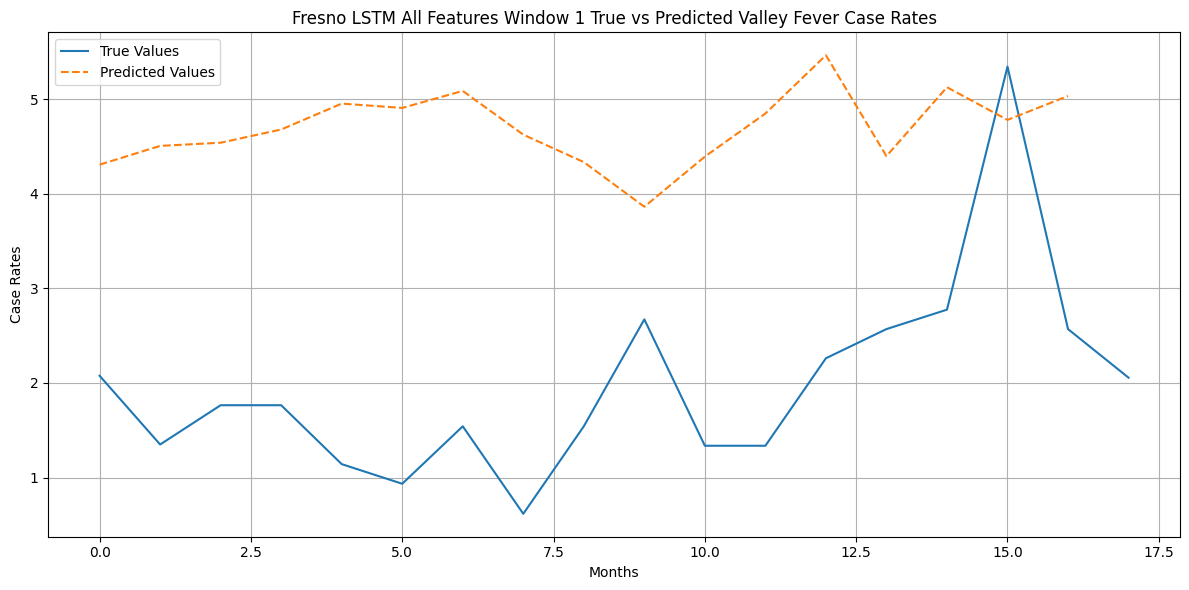

Epoch 1/300 - Training Loss 0.3043, Testing Loss 0.0816
Epoch 11/300 - Training Loss 0.2439, Testing Loss 0.1228
Epoch 21/300 - Training Loss 0.2184, Testing Loss 0.2153
Epoch 31/300 - Training Loss 0.2215, Testing Loss 0.2338
Epoch 41/300 - Training Loss 0.2155, Testing Loss 0.1993
Epoch 51/300 - Training Loss 0.2162, Testing Loss 0.1985
Epoch 61/300 - Training Loss 0.2165, Testing Loss 0.2128
Epoch 71/300 - Training Loss 0.2155, Testing Loss 0.2125
Epoch 81/300 - Training Loss 0.2161, Testing Loss 0.2084
Epoch 91/300 - Training Loss 0.2096, Testing Loss 0.2134
Epoch 101/300 - Training Loss 0.2076, Testing Loss 0.2120
Epoch 111/300 - Training Loss 0.2013, Testing Loss 0.2137
Epoch 121/300 - Training Loss 0.1943, Testing Loss 0.2172
Epoch 131/300 - Training Loss 0.1882, Testing Loss 0.2109
Epoch 141/300 - Training Loss 0.1887, Testing Loss 0.1995
Epoch 151/300 - Training Loss 0.1876, Testing Loss 0.2002
Epoch 161/300 - Training Loss 0.1828, Testing Loss 0.1928
Epoch 171/300 - Training 

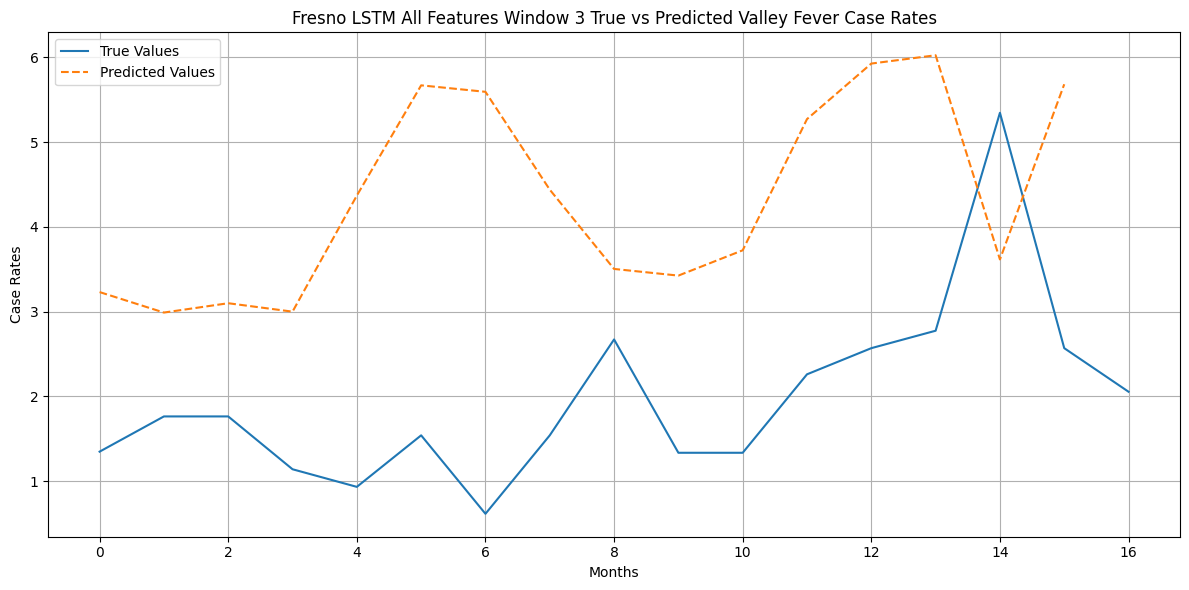

Epoch 1/300 - Training Loss 0.3785, Testing Loss 0.1308
Epoch 11/300 - Training Loss 0.2668, Testing Loss 0.0946
Epoch 21/300 - Training Loss 0.2272, Testing Loss 0.2527
Epoch 31/300 - Training Loss 0.2185, Testing Loss 0.1990
Epoch 41/300 - Training Loss 0.2181, Testing Loss 0.1753
Epoch 51/300 - Training Loss 0.2171, Testing Loss 0.2073
Epoch 61/300 - Training Loss 0.2150, Testing Loss 0.1995
Epoch 71/300 - Training Loss 0.2110, Testing Loss 0.1922
Epoch 81/300 - Training Loss 0.2077, Testing Loss 0.2003
Epoch 91/300 - Training Loss 0.2017, Testing Loss 0.1906
Epoch 101/300 - Training Loss 0.1905, Testing Loss 0.1812
Epoch 111/300 - Training Loss 0.1774, Testing Loss 0.1691
Epoch 121/300 - Training Loss 0.1635, Testing Loss 0.1770
Epoch 131/300 - Training Loss 0.1593, Testing Loss 0.1521
Epoch 141/300 - Training Loss 0.1605, Testing Loss 0.1501
Epoch 151/300 - Training Loss 0.1491, Testing Loss 0.1438
Epoch 161/300 - Training Loss 0.1403, Testing Loss 0.1460
Epoch 171/300 - Training 

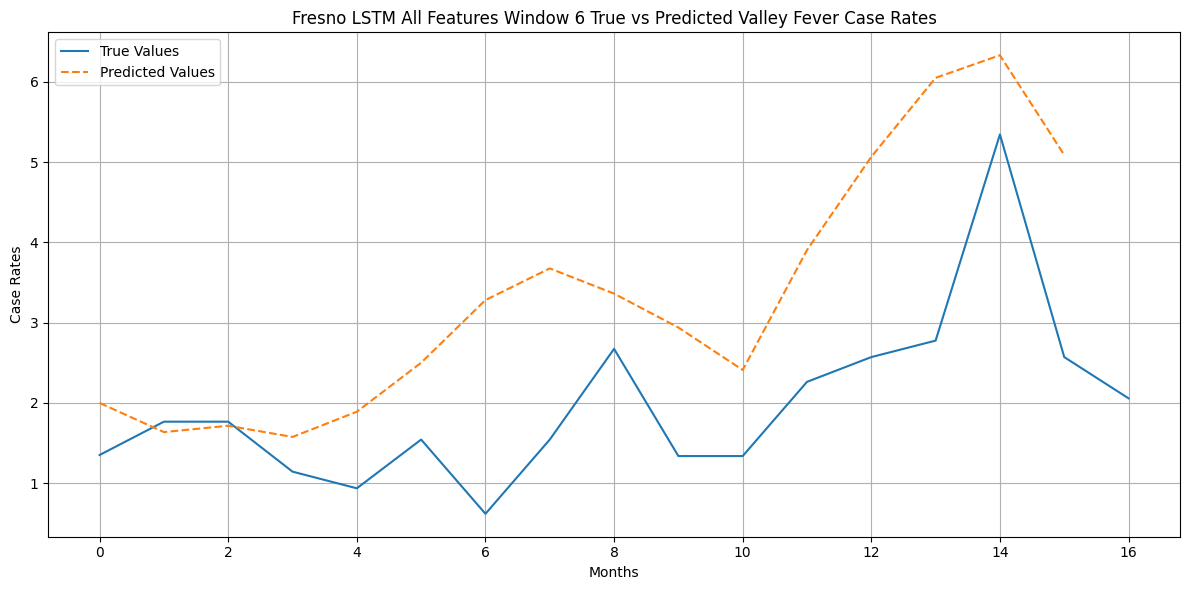

Epoch 1/300 - Training Loss 0.2574, Testing Loss 0.1102
Epoch 11/300 - Training Loss 0.2263, Testing Loss 0.2146
Epoch 21/300 - Training Loss 0.2249, Testing Loss 0.2089
Epoch 31/300 - Training Loss 0.2229, Testing Loss 0.1837
Epoch 41/300 - Training Loss 0.2202, Testing Loss 0.2026
Epoch 51/300 - Training Loss 0.2097, Testing Loss 0.1875
Epoch 61/300 - Training Loss 0.1921, Testing Loss 0.1717
Epoch 71/300 - Training Loss 0.1719, Testing Loss 0.1423
Epoch 81/300 - Training Loss 0.1548, Testing Loss 0.1301
Epoch 91/300 - Training Loss 0.1491, Testing Loss 0.1281
Epoch 101/300 - Training Loss 0.1335, Testing Loss 0.1231
Epoch 111/300 - Training Loss 0.1267, Testing Loss 0.1204
Epoch 121/300 - Training Loss 0.1162, Testing Loss 0.1332
Epoch 131/300 - Training Loss 0.1058, Testing Loss 0.1374
Epoch 141/300 - Training Loss 0.1046, Testing Loss 0.1334
Epoch 151/300 - Training Loss 0.0998, Testing Loss 0.1269
Epoch 161/300 - Training Loss 0.0913, Testing Loss 0.1297
Epoch 171/300 - Training 

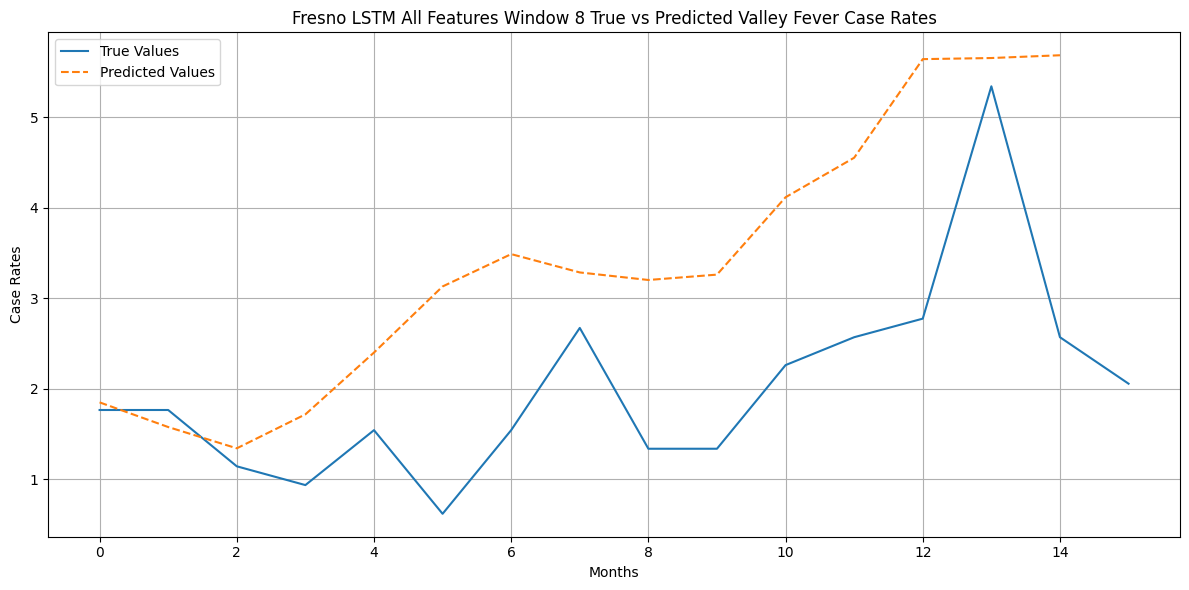

Epoch 1/300 - Training Loss 0.3693, Testing Loss 0.1272
Epoch 11/300 - Training Loss 0.2422, Testing Loss 0.1526
Epoch 21/300 - Training Loss 0.2351, Testing Loss 0.2253
Epoch 31/300 - Training Loss 0.2304, Testing Loss 0.1573
Epoch 41/300 - Training Loss 0.2282, Testing Loss 0.1913
Epoch 51/300 - Training Loss 0.2250, Testing Loss 0.1858
Epoch 61/300 - Training Loss 0.2192, Testing Loss 0.1777
Epoch 71/300 - Training Loss 0.2071, Testing Loss 0.1641
Epoch 81/300 - Training Loss 0.1784, Testing Loss 0.1112
Epoch 91/300 - Training Loss 0.1570, Testing Loss 0.0667
Epoch 101/300 - Training Loss 0.1472, Testing Loss 0.0726
Epoch 111/300 - Training Loss 0.1285, Testing Loss 0.0650
Epoch 121/300 - Training Loss 0.1080, Testing Loss 0.0678
Epoch 131/300 - Training Loss 0.0959, Testing Loss 0.0647
Epoch 141/300 - Training Loss 0.0932, Testing Loss 0.0632
Epoch 151/300 - Training Loss 0.0888, Testing Loss 0.0660
Epoch 161/300 - Training Loss 0.0808, Testing Loss 0.0641
Epoch 171/300 - Training 

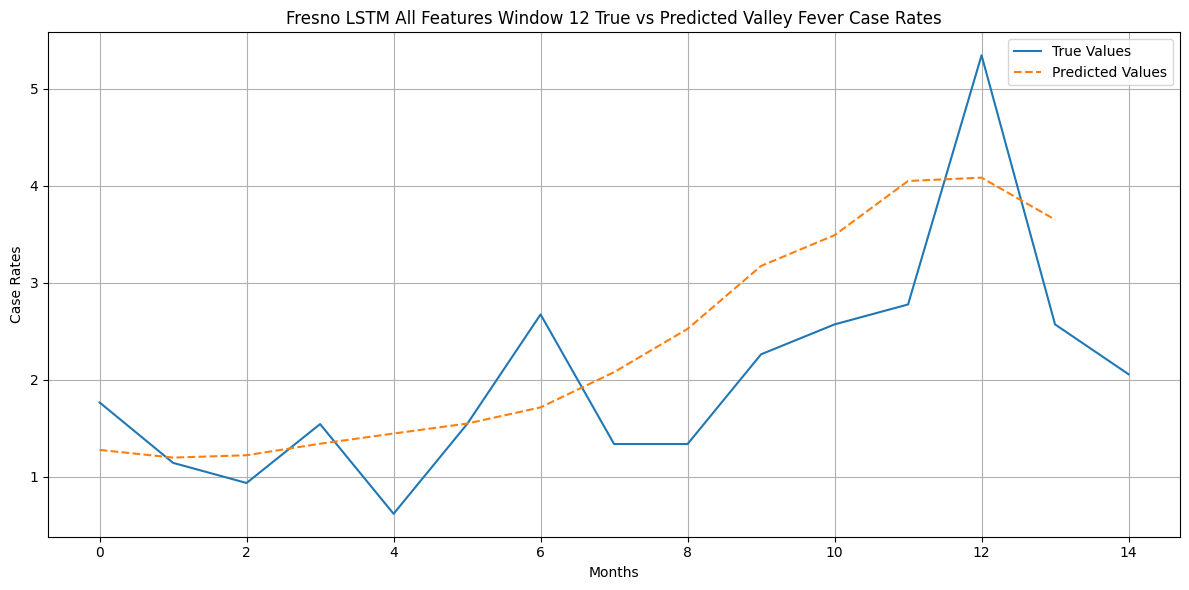

In [9]:
# using the code above, lets run the LSTM model on the full feature vector X with the sliding window varying
# vary the window size as well here
window_size = [1, 2, 4, 6, 8, 12] # change the index to vary the window size
# prep the data using the function you made 
print(X.shape)
for window_size in sliding_window_sizes:
    X_train, X_test, y_train, y_test = preprocess_data(X, y, feature_index=None, window_size=window_size)
    # scale the data
    X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = scale_data(X_train, X_test, y_train, y_test)
    # Convert to PyTorch tensors and reshape for LSTM input
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    X_test_tensor  = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32).view(-1, 1)
    y_test_tensor  = torch.tensor(y_test_scaled, dtype=torch.float32).view(-1, 1) 
    # Initialize the model
    model = LSTM(input_size=len(feature_columns), hidden_size=hidden_size, num_layers=num_layers, dropout=dropout)
    # Define optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    # Create Trainer instance
    trainer = TrainerNewNew(model, criterion, optimizer, scaler_y)
    # Train the model
    history, train_preds_inv, y_train_true = trainer.train(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, epochs)
    # Evaluate the model
    y_pred_inv, y_true_inv = trainer.evaluate(X_test_tensor, y_test_tensor)
    # Calculate RMSE for test set
    rmse = np.sqrt(np.mean((y_pred_inv - y_true_inv) ** 2))
    # Store results
    results.append({
        'feature': 'All Features',
        'window_size': window_size,
        'rmse': rmse
    })  

    # visualize the output
    trainer.visualize_results(y_true_inv, y_pred_inv, county_name="Fresno", model_type="LSTM", title_text=f"All Features Window {window_size}", show_plot=True, save_fig=False) 

In [10]:
results_df = pd.DataFrame(results)
results_df

feature  window_size      rmse
0   FIRE_Acres_Burned            1  2.676680
1   FIRE_Acres_Burned            3  2.342167
2   FIRE_Acres_Burned            6  1.768919
3   FIRE_Acres_Burned            8  1.696288
4   FIRE_Acres_Burned           12  1.367813
5              PRECIP            1  2.750907
6              PRECIP            3  2.808534
7              PRECIP            6  2.621768
8              PRECIP            8  2.202594
9              PRECIP           12  1.111840
10    WIND_EventCount            1  2.845279
11    WIND_EventCount            3  2.888592
12    WIND_EventCount            6  2.873012
13    WIND_EventCount            8  2.866842
14    WIND_EventCount           12  2.660725
15        WIND_AvgMPH            1  2.787785
16        WIND_AvgMPH            3  2.719769
17        WIND_AvgMPH            6  2.678015
18        WIND_AvgMPH            8  2.530825
19        WIND_AvgMPH           12  2.667314
20      WIND_RunMiles            1  2.778197
21      WIND_RunMiles            3  2.701296
22      WIND_RunMiles            6  2.662232
23      WIND_RunMiles            8  2.559958
24      WIND_RunMiles           12  3.077941
25           AQI_PM25            1  2.709313
26           AQI_PM25            3  2.763447
27           AQI_PM25            6  3.111865
28           AQI_PM25            8  3.128555
29           AQI_PM25           12  4.356662
30           AQI_PM10            1  2.740886
31           AQI_PM10            3  2.738492
32           AQI_PM10            6  2.861224
33           AQI_PM10            8  2.516838
34           AQI_PM10           12  1.545109
35   EARTHQUAKE_Total            1  2.773410
36   EARTHQUAKE_Total            3  2.735834
37   EARTHQUAKE_Total            6  2.838772
38   EARTHQUAKE_Total            8  2.717624
39   EARTHQUAKE_Total           12  2.604525
40    PESTICIDE_Total            1  2.753007
41    PESTICIDE_Total            3  2.763619
42    PESTICIDE_Total            6  2.858400
43    PESTICIDE_Total            8  2.597841
44    PESTICIDE_Total           12  2.126119
45       All Features            1  2.872029
46       All Features            3  2.544319
47       All Features            6  1.647404
48       All Features            8  1.648836
49       All Features           12  0.829351

In [11]:
# save this data frame as a csv 
results_df.to_csv("../../data/fresno_lstm_feature_window_results.csv", index=False)

In [12]:
# for each feature, what is the sliding window that has the lowest RMSE?
best_results = results_df.loc[results_df.groupby('feature')['rmse'].idxmin()]
best_results

feature  window_size      rmse
34           AQI_PM10           12  1.545109
25           AQI_PM25            1  2.709313
49       All Features           12  0.829351
39   EARTHQUAKE_Total           12  2.604525
4   FIRE_Acres_Burned           12  1.367813
44    PESTICIDE_Total           12  2.126119
9              PRECIP           12  1.111840
18        WIND_AvgMPH            8  2.530825
14    WIND_EventCount           12  2.660725
23      WIND_RunMiles            8  2.559958

In [13]:
# save this as a csv as well
best_results.to_csv("../../data/fresno_lstm_best_feature_window_results.csv", index=False)

# Creating custom length feature vectors with individual sliding windows

In [14]:
# given each feature and its sliding window size, we need to 
# create a total feature vector that has the correct sliding window sizes for each feature
# use the dictionary of the best_results to pull each sliding window per feature besides the "All Features" one
# then we can create a custom feature vector with the correct sliding windows for each feature
# then we can run the LSTM on this custom feature vector and see how it performs

# make a new preprocess function that uses this best_results dict to 
# make a new feature vector with the correct sliding windows per feature

def custom_preprocess_data(X, y, best_results, test_size=0.2):
  feature_indices = {feature: idx for idx, feature in enumerate(feature_columns)}
  feature_windows = {row['feature']: row['window_size'] for _, row in best_results.iterrows() if row['feature'] != 'All Features'}
  
  # Create sequences for LSTM
  X_sequences, y_sequences = [], []
  max_window_size = max(feature_windows.values())
  
  for i in range(len(X) - max_window_size):
    feature_vector = []
    for feature, window_size in feature_windows.items():
      feature_index = feature_indices[feature]
      feature_segment = X[i + max_window_size - window_size:i + max_window_size, feature_index]
      feature_vector.extend(feature_segment)
    
    X_sequences.append(feature_vector)
    y_sequences.append(y[i + max_window_size])
  
  X_sequences = np.array(X_sequences)
  y_sequences = np.array(y_sequences)

  # Train-test split
  split_index = int(len(X_sequences) * (1 - test_size))
  X_train, X_test = X_sequences[:split_index], X_sequences[split_index:]
  y_train, y_test = y_sequences[:split_index], y_sequences[split_index:]

  return X_train, X_test, y_train, y_test
  
X_train, X_test, y_train, y_test = custom_preprocess_data(X, y, best_results)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(60, 89) (15, 89) (60,) (15,)


In [ ]:
# we want to create a feature vector sequence X that utilizes all of the unique sliding window sizes.
# The longest value will be the length of the sequence for each column, but for the values with a smaller sliding window 
# we will pad with zeros. This way we can keep the same sequence length for each feature. We will make this into a function
# in case we need this later
def padded_preprocess_data(X, y, best_results, test_size=0.2):
  feature_indices = {feature: idx for idx, feature in enumerate(feature_columns)}
  feature_windows = {row['feature']: row['window_size'] for _, row in best_results.iterrows() if row['feature'] != 'All Features'}
  
  # Create sequences for LSTM
  X_sequences, y_sequences = [], []
  max_window_size = max(feature_windows.values())
  
  for i in range(len(X) - max_window_size):
    feature_vector = []
    for feature, window_size in feature_windows.items():
      feature_index = feature_indices[feature]
      feature_segment = X[i + max_window_size - window_size:i + max_window_size, feature_index]
      # Pad with zeros if the window size is less than the max window size
      if window_size < max_window_size:
        padding = np.zeros(max_window_size - window_size)
        feature_segment = np.concatenate((padding, feature_segment))
      feature_vector.extend(feature_segment)
    
    X_sequences.append(feature_vector)
    y_sequences.append(y[i + max_window_size])
  
  X_sequences = np.array(X_sequences)
  y_sequences = np.array(y_sequences)

  # Train-test split
  split_index = int(len(X_sequences) * (1 - test_size))
  X_train, X_test = X_sequences[:split_index], X_sequences[split_index:]
  y_train, y_test = y_sequences[:split_index], y_sequences[split_index:]

  return X_train, X_test, y_train, y_test